In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader,Dataset
from torch import nn

import altair as alt
import logomaker
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
random.seed(7) #10



import utils as u

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'

COND_COLS = ['carbon_source','oxygen_level','nitrate_level',
             'copper_level','lanthanum_level','growth_rate',
             'growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
tpm_df.head()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...,1318,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...,1102,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...,1081,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...,2416,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
4,EQU24_RS00025,hypothetical protein,CDS,,NZ_CP035467.1,6825,7062,Derived by automated computational analysis us...,VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...,238,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192


In [5]:
locus2info = u.make_info_dict(tpm_df)
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [6]:
df_means = u.get_gene_means_by_condition(tpm_df,samples,sample2condition)

In [7]:
df_means

locus_tag,exp_condition,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
0,LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
1,MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
2,NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
3,NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
4,NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
5,WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
6,WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
7,aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
8,crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496
9,highCu,47.851477,79.099490,33.524043,73.320408,48.652214,33.976359,92.989818,51.940784,50.360579,...,8132.537467,48.884308,35.598730,46.099300,30.115207,89.700150,342.971435,386.483127,1021.443762,1692.391154


In [8]:
df_means[['exp_condition','EQU24_RS19315']]

locus_tag,exp_condition,EQU24_RS19315
0,LanzaTech,93521.364184
1,MeOH,16719.112094
2,NO3_lowO2_slow_growth,60408.950994
3,NoCu,24089.831885
4,NoLanthanum,59550.979808
5,WT_control,60078.573354
6,WithLanthanum,54301.949686
7,aa3_KO,71478.626675
8,crotonic_acid,43279.867708
9,highCu,45252.320722


In [9]:
# filter to only the copper conditions
cu_conds = ['NoCu','lowCu','medCu','highCu']

df_means_cu = df_means[df_means['exp_condition'].isin(cu_conds)]
df_means_cu

locus_tag,exp_condition,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
3,NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
9,highCu,47.851477,79.099490,33.524043,73.320408,48.652214,33.976359,92.989818,51.940784,50.360579,...,8132.537467,48.884308,35.598730,46.099300,30.115207,89.700150,342.971435,386.483127,1021.443762,1692.391154
12,lowCu,42.963556,61.199155,28.818713,61.563321,50.956799,31.309574,75.037593,40.028670,35.321019,...,7157.334557,43.376082,33.564108,36.862718,31.889782,66.733497,293.589291,313.731841,843.597251,1123.659681
15,medCu,44.910897,65.001074,29.409165,65.383162,48.719958,26.307981,80.114744,39.235705,32.118273,...,5934.158113,43.944096,36.386184,34.983692,32.897138,84.616668,340.021564,377.209038,1060.040784,1429.583942


In [10]:
# transpose to get genes as examples again and add upstream region
XYdf = df_means_cu.set_index('exp_condition').T.reset_index()
XYdf['upstream_region'] = XYdf['locus_tag'].apply(lambda x: loc2seq[x])
XYdf = XYdf[['locus_tag','upstream_region']+cu_conds]

XYdf

exp_condition,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,44.338687,42.963556,44.910897,47.851477
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,59.619360,61.199155,65.001074,79.099490
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,28.258717,28.818713,29.409165,33.524043
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,56.808319,61.563321,65.383162,73.320408
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,49.829406,50.956799,48.719958,48.652214
...,...,...,...,...,...,...
4208,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,65.329879,66.733497,84.616668,89.700150
4209,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,253.598495,293.589291,340.021564,342.971435
4210,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,273.274694,313.731841,377.209038,386.483127
4211,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,731.042190,843.597251,1060.040784,1021.443762


In [11]:
loc2seq["EQU24_RS19315"]

'GCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA'

In [12]:
class MultiTaskDataset(Dataset):
    def __init__(self,df):
        self.loci = list(df['locus_tag'])
        self.seqs = list(df['upstream_region'])
        self.seq_len = len(self.seqs[0])
    
        self.nocu_labels = list(df['NoCu'])
        self.lowcu_labels = list(df['lowCu'])
        self.medcu_labels = list(df['medCu'])
        self.highcu_labels = list(df['highCu'])
        
    def __len__(self): return len(self.loci)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        nocu = torch.tensor(float(self.nocu_labels[idx]))
        lowcu = torch.tensor(float(self.lowcu_labels[idx]))
        medcu = torch.tensor(float(self.medcu_labels[idx]))
        highcu = torch.tensor(float(self.highcu_labels[idx]))
        
        return seq, (nocu, lowcu, medcu, highcu)
        

In [13]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


def build_dataloaders(df,batch_size=32):
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    # put into dataloader object
    train_ds = MultiTaskDataset(train_df)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    test_ds = MultiTaskDataset(test_df)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl,train_df,test_df

In [14]:
# did this actually work???
train_dl, test_dl,train_df, test_df = build_dataloaders(XYdf)

In [15]:
NOCU_IDX=0
LOWCU_IDX=1
MEDCU_IDX=2
HIGHCU_IDX=3

class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        self.seq_len = seq_len
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.nocu_obj   = nn.Linear(h2_size,1)
        self.lowcu_obj  = nn.Linear(h2_size,1)
        self.medcu_obj  = nn.Linear(h2_size,1)
        self.highcu_obj = nn.Linear(h2_size,1)
        
        

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)

        out = self.lin_share(xb)
        
        out_nocu = self.nocu_obj(out)
        out_lowcu = self.lowcu_obj(out)
        out_medcu = self.medcu_obj(out)
        out_highcu = self.highcu_obj(out)
        
        return [out_nocu, out_lowcu, out_medcu, out_highcu]
    


In [18]:
def loss_batch_multi(model, loss_func, xb, yb, opt=None,verbose=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    nocu_target = yb[0].unsqueeze(1).float()
    lowcu_target = yb[1].unsqueeze(1).float()
    medcu_target = yb[2].unsqueeze(1).float()
    highcu_target = yb[3].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_nocu = loss_func(res[0], nocu_target)
    loss_lowcu = loss_func(res[1], lowcu_target)
    loss_medcu = loss_func(res[2], medcu_target)
    loss_highcu = loss_func(res[3], highcu_target)
    
    #loss = sum([loss_nocu, loss_lowcu, loss_medcu, loss_highcu])
    loss = torch.mean(torch.stack([loss_nocu, loss_lowcu, loss_medcu, loss_highcu]))
    
    if verbose:
        print("what is 'loss'?:")
        print(loss_nocu)
        print(loss_lowcu)
        print(loss_medcu)
        print(loss_highcu)
        print("*****")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit_multi(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch_multi(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch_multi(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

Seq len: 100
Epoch: 0
0 5196278.757265718
Epoch: 1
1 5177017.679418743
Epoch: 2
2 5167146.972123369
Epoch: 3
3 5164077.725088968
Epoch: 4
4 5160845.712930012
Epoch: 5
5 5160499.476571768
Epoch: 6
6 5160059.357651246
Epoch: 7
7 5159583.676156583
Epoch: 8
8 5159583.728054567
Epoch: 9
9 5159739.1316725975


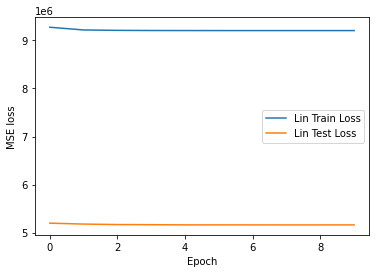

In [47]:
# faster learning rate
h1 = 10
h2 = 100
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.01) 

epochs = 10
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

lin_train_losses, lin_val_losses = fit_multi(
    epochs, 
    multi_lin_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

lin_data_label = list(zip([lin_train_losses,
                           lin_val_losses], 
                          ['Lin Train Loss',
                           'Lin Test Loss']))
u.quick_loss_plot(lin_data_label)

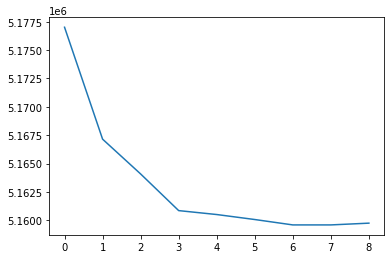

In [48]:
#plt.plot(lin_train_losses[1:])
plt.plot(lin_val_losses[1:])

In [21]:
print(train_losses)
print(val_losses)

[152387980.80526707, 9381289.893054524, 9266386.060330119, 9226386.503767155, 9212924.82474963, 9208349.040300446, 9206837.052997496, 9206238.83346161, 9206076.047779117, 9205852.470968565]
[5505467.159549229, 5293462.516014235, 5215086.122034401, 5182619.678084223, 5170542.086298932, 5164468.900948992, 5162640.816132858, 5160612.328291815, 5159770.954033215, 5160390.050118624]


In [47]:
# # slower learning rate
# h1 = 40
# h2 = 20
# multi_lin_model = DNA_Linear_Multi(100, h1,h2)

# loss_func = torch.nn.MSELoss() 
# optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.0001)

# epochs = 50
# train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

In [48]:
# plt.plot(train_losses,label="train")
# plt.plot(val_losses,label="val")
# plt.legend()
# plt.show()

In [49]:
# plt.plot(val_losses,label="val")
# plt.legend()
# plt.show()

In [21]:
test_df.sort_values('highCu',ascending=False).head(40)

exp_condition,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
3760,EQU24_RS19765,TCACCGCTCACCGCTCACCGCTCACCGCTCACCGCTCACCGCTCAC...,50999.260623,46269.078793,65767.392566,61364.509258
3670,EQU24_RS19310,CTGTAAAAACTATCTCCTGGTCGCTTCTTCTTCATTGAAGAAGCGA...,5136.661241,12401.299762,20503.768153,27913.263166
4203,EQU24_RS22110,ATCTACGTTAGAATGGACAACGCTAAGTAGCTTTAATTTGATGGAA...,8345.775345,7157.334557,5934.158113,8132.537467
801,EQU24_RS04160,ACCGCGAACTGGAATTACATCTGCAGGAAAGCCTGATAAAAATGAG...,6350.485757,5372.432663,4351.889675,7600.092547
3442,EQU24_RS18130,GCGCCGTCAAGACATCGATCGAATTTTGAGCGCCGAGGGCATACCG...,7065.130727,7409.331740,6750.336201,6994.990478
1967,EQU24_RS10370,CGTCTGGAATGAGATGACGGGATTTCTAAGTAAAACAAATAACTAT...,2955.004150,3133.414413,3157.406172,3783.788118
3428,EQU24_RS18060,CAGGTTAACCTTCAGAAACAATAAATAAACTTGAAAAACCCTAGCG...,1871.522494,2000.806423,3113.617052,2925.083231
771,EQU24_RS04005,AGGATTATCGCTAGGTATGCGCCTAGAAAATTGGCCTCCTGATAAT...,1770.500815,2010.224717,2389.932533,2859.036742
670,EQU24_RS03495,CCTCGTTACGTTCTGCCATTAAGAGATTTCACTATTTCTTAGCTAG...,1836.055573,2341.201502,3016.360348,2771.548600
728,EQU24_RS03790,GGGTTCCCGAGTGGCCAAAGGGATCAGACTGTAAATCTGCCGGCTC...,2093.681395,2274.039011,2516.951996,2763.440595


In [22]:
train_df.sort_values('highCu',ascending=False).head(40)

exp_condition,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
2378,EQU24_RS12525,TATGCGAACGATGCAGAAACGGAAAGAGGCAAGTTCGAAGCGCGAT...,169237.818591,176867.896910,170727.480805,153361.821049
3671,EQU24_RS19315,GCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGG...,24089.831885,31547.936460,36520.493325,45252.320722
3669,EQU24_RS19305,GTTCTTGATACAAACTTAATAATCAAAAAACCACGGTATATTCATT...,6095.068053,12603.921420,21233.265994,27205.564156
3075,EQU24_RS16195,ATTCAATTTCGGCGAACAAGCTCTATAACTGACTTTTATAGAGTCC...,5126.141380,8375.005794,10479.981314,15889.972707
3441,EQU24_RS18125,AATACCGATGAAATGCTGAAAATTATGGCGTTCATTCGCAGCATTT...,17093.106832,16089.167704,15776.560986,12644.724886
3444,EQU24_RS18140,TCGTTATGCGCCTTGATCAAGCTAAGCCGGTTGTAACAACAAACAC...,12402.003629,12737.345019,10970.697860,10660.658376
2298,EQU24_RS12095,TTTGAATTTTTACGTTAAATCCCCTATTCTTTGCGGCTTTAACTTT...,6421.576484,6147.896580,7314.585294,7685.879048
1733,EQU24_RS09110,TAGCAATTCGAATTGCTAATGGGTCTTCAAAACGGATTTACACTTA...,5372.051979,5310.824345,6694.910868,7583.137782
2990,EQU24_RS15745,ACTGAAATTTAAATTGCTTTCCTGATTAGCCGGCTTTATTATAAGA...,5218.974830,5503.118333,6782.815936,6299.954989
2462,EQU24_RS12965,TAGTTCTGGAATATTTTGAAAAAAAAGTTCAATATATTTCATCGAA...,5248.383436,4829.979294,4036.981580,5661.736644


In [54]:
TASKS = {
    0:"NoCu",
    1:"lowCu",
    2:"medCu",
    3:"highCu"
}

def alt_parity_plot_multi(model_name,df, pearson,task):
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.X('pred:Q'),
        alt.Y('truth:Q'),
        alt.Color('task:N'),
        tooltip=['locus_tag:N','gene:N','product:N','type:N']
    ).properties(
        title=f'Model:{model_name} (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model_name}.html')
    
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,x='pred',y='truth',hue='task',alpha=0.2)
    plt.xlabel("Predicted Score",fontsize=14)
    plt.ylabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()
    
    
def parity_pred_multi(models, genes, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]
#             print(f"{gene}:{dna}")
#             print(preds)
            
            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],TASKS[i]))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task'])
        pearson = df['truth'].corr(df['pred'])
        df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
        df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
        df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [55]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [56]:
# oracle_multi = dict([(a,
#                       {"noCu":b,
#                        "lowCu":c,
#                        "medCu":d,
#                        "highCu":e}) for a,b,c,d,e in XYdf[['locus_tag','NoCu','lowCu','medCu','highCu']].values])


oracle_multi = dict([(a,(b,c,d,e)) for a,b,c,d,e in XYdf[['locus_tag','NoCu','lowCu','medCu','highCu']].values])

In [57]:
oracle_multi['EQU24_RS12525']

(169237.81859133218, 176867.89691024864, 170727.48080539587, 153361.8210492924)

Running LinearDeep


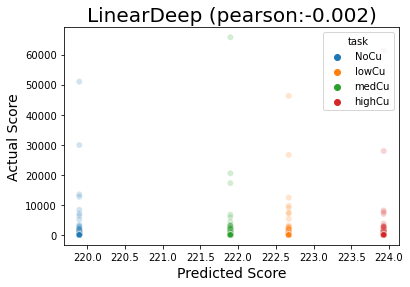

In [58]:
models = [
    ("LinearDeep",multi_lin_model),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = test_df['locus_tag'].values
task = "cu_test"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

In [41]:
loc = 'EQU24_RS19315'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)

print(dna)
print(s)
multi_lin_model(s.float())

GCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA
tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
        

[tensor([[218.1966]], grad_fn=<AddmmBackward>),
 tensor([[220.7281]], grad_fn=<AddmmBackward>),
 tensor([[219.4645]], grad_fn=<AddmmBackward>),
 tensor([[222.1283]], grad_fn=<AddmmBackward>)]

In [42]:
loc = 'EQU24_RS12525'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
print(dna)
print(s)
multi_lin_model(s.float())

TATGCGAACGATGCAGAAACGGAAAGAGGCAAGTTCGAAGCGCGATAATAAATTAACATTTGCTAATGATGAATTTAATTGTTAATATCGCGCAACACTA
tensor([[[0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
        

[tensor([[218.1966]], grad_fn=<AddmmBackward>),
 tensor([[220.7281]], grad_fn=<AddmmBackward>),
 tensor([[219.4645]], grad_fn=<AddmmBackward>),
 tensor([[222.1283]], grad_fn=<AddmmBackward>)]

In [46]:
print(np.mean(train_df['NoCu'].values))
print(np.mean(train_df['lowCu'].values))
print(np.mean(train_df['medCu'].values))
print(np.mean(train_df['highCu'].values))

223.6825874345999
226.31727460765623
224.98447323233552
226.95637085919805


In [53]:
multi_lin_model.lin_share.state_dict()

OrderedDict([('0.weight',
              tensor([[-5.4317e-02, -2.6751e-02, -9.4373e-03,  ..., -4.7642e-02,
                        1.8052e-02, -5.7191e-02],
                      [-1.1546e-01, -4.8048e-02, -4.8892e-03,  ..., -3.2037e-02,
                       -2.6154e-02, -9.7378e-02],
                      [-2.0379e-01, -3.6035e-01, -6.8613e-01,  ..., -4.1202e-01,
                       -3.9521e-01, -4.1410e-01],
                      ...,
                      [-1.9124e+00, -1.0771e+01, -6.2945e+00,  ..., -4.7654e+00,
                       -1.6924e+00, -9.9184e+00],
                      [-3.8112e+01, -2.1268e+02, -1.2547e+02,  ..., -9.3992e+01,
                       -3.3036e+01, -1.9554e+02],
                      [-3.4898e+01, -1.9536e+02, -1.1512e+02,  ..., -8.6206e+01,
                       -3.0313e+01, -1.7944e+02]])),
             ('0.bias',
              tensor([-2.7763e-02, -1.1272e-01, -1.5397e+00, -4.5495e-02, -1.1986e+03,
                      -4.6477e+01, -9.3282e-02,

In [32]:
pred_df[pred_df['task']=='NoCu']

,locus_tag,truth,pred,task,gene,product,type
0,EQU24_RS00005,44.338687,218.196579,NoCu,dnaA,chromosomal replication initiator protein DnaA,CDS
4,EQU24_RS00025,49.829406,218.196579,NoCu,,hypothetical protein,CDS
8,EQU24_RS00040,40.491969,218.196579,NoCu,,TolC family protein,CDS
12,EQU24_RS00070,5.942885,218.196579,NoCu,tatA,twin-arginine translocase TatA/TatE family sub...,CDS
16,EQU24_RS00075,4.448951,218.196579,NoCu,tatB,twin-arginine translocase subunit TatB,CDS
...,...,...,...,...,...,...,...
3352,EQU24_RS22070,35.366127,218.196579,NoCu,,VWA domain-containing protein,CDS
3356,EQU24_RS22075,38.887622,218.196579,NoCu,,DUF4381 domain-containing protein,CDS
3360,EQU24_RS22085,49.585994,218.196579,NoCu,,MoxR family ATPase,CDS
3364,EQU24_RS22090,20.705094,218.196579,NoCu,,POT family MFS transporter,CDS


### WEIRDNESS: all input sequences are seeming to predict the same output value for each task.
Maybe this is a bug? But also maybe this just means the model is bad an only predicting the bias? The values are pretty close the mean

Seq len: 100
Epoch: 0
0 5236866.211150653
Epoch: 1
1 5236567.508600237
Epoch: 2
2 5224942.59252669
Epoch: 3
3 5166954.080367735
Epoch: 4
4 5236812.420521946
Epoch: 5
5 5236679.640272835
Epoch: 6
6 5236606.414294187
Epoch: 7
7 5236524.84104389
Epoch: 8
8 5236409.116844603
Epoch: 9
9 5236036.084519573
Epoch: 10
10 5220795.557384342
Epoch: 11
11 5236521.693653618
Epoch: 12
12 5236330.313760379
Epoch: 13
13 5236172.747627521
Epoch: 14
14 5236095.5462633455
Epoch: 15
15 5236022.212633452
Epoch: 16
16 5235945.243179122
Epoch: 17
17 5235862.265421115
Epoch: 18
18 5235770.65539739
Epoch: 19
19 5235662.465005931


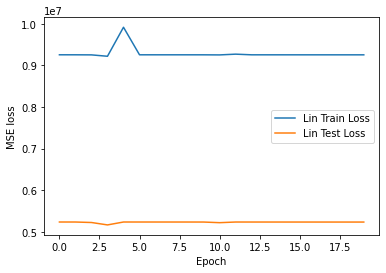

In [98]:
# faster learning rate
h1 = 10
h2 = 10
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.00001) 

epochs = 20
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

lin_train_losses, lin_val_losses = fit_multi(
    epochs, 
    multi_lin_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

lin_data_label = list(zip([lin_train_losses,
                           lin_val_losses], 
                          ['Lin Train Loss',
                           'Lin Test Loss']))
u.quick_loss_plot(lin_data_label)

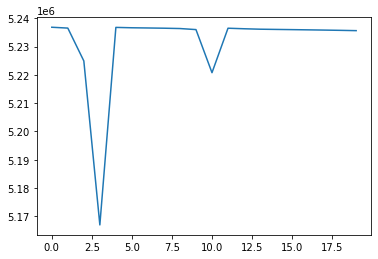

In [99]:
plt.plot(lin_val_losses)

In [100]:
lin_val_losses

[5236866.211150653,
 5236567.508600237,
 5224942.59252669,
 5166954.080367735,
 5236812.420521946,
 5236679.640272835,
 5236606.414294187,
 5236524.84104389,
 5236409.116844603,
 5236036.084519573,
 5220795.557384342,
 5236521.693653618,
 5236330.313760379,
 5236172.747627521,
 5236095.5462633455,
 5236022.212633452,
 5235945.243179122,
 5235862.265421115,
 5235770.65539739,
 5235662.465005931]

Running LinearDeep


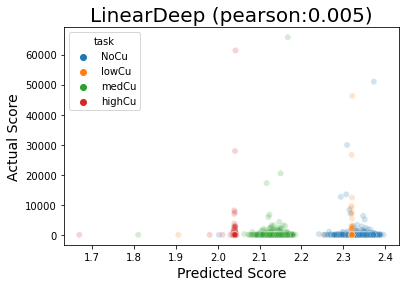

In [101]:
models = [
    ("LinearDeep",multi_lin_model),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = test_df['locus_tag'].values
task = "cu_test"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

In [102]:
loc = 'EQU24_RS12525'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
print(dna)
multi_lin_model(s.float())

TATGCGAACGATGCAGAAACGGAAAGAGGCAAGTTCGAAGCGCGATAATAAATTAACATTTGCTAATGATGAATTTAATTGTTAATATCGCGCAACACTA


[tensor([[1.9436]], grad_fn=<AddmmBackward>),
 tensor([[2.3091]], grad_fn=<AddmmBackward>),
 tensor([[1.8283]], grad_fn=<AddmmBackward>),
 tensor([[2.0203]], grad_fn=<AddmmBackward>)]

In [103]:
loc = 'EQU24_RS00005'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
print(dna)
multi_lin_model(s.float())

CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT


[tensor([[2.3408]], grad_fn=<AddmmBackward>),
 tensor([[2.3207]], grad_fn=<AddmmBackward>),
 tensor([[2.1418]], grad_fn=<AddmmBackward>),
 tensor([[2.0407]], grad_fn=<AddmmBackward>)]

## OK, instead of trying to debug a knowingly bad model, let's start to try to create better ones??

In [155]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=8,
                 lin_share_size=10,
                 lin_share_size2 = 10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            #nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
            nn.Linear(lin_share_size, lin_share_size2),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.nocu_obj    = nn.Linear(lin_share_size2,1)
        self.lowcu_obj   = nn.Linear(lin_share_size2,1)
        self.medcu_obj   = nn.Linear(lin_share_size2,1)
        self.highcu_obj  = nn.Linear(lin_share_size2,1)
        
        
    def forward(self, xb):
        # permute to puts channel in correct order
        # unsqueeze adds dimension for conv2d
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix?? I think the unsqueeze adds a necessary dimension for Conv2D?
        #print(xb.shape)
        
        out = self.conv_share(xb)
        
        nocu_out   = self.nocu_obj(out)
        lowcu_out  = self.lowcu_obj(out)
        medcu_out  = self.medcu_obj(out)
        highcu_out = self.highcu_obj(out)
        
        return (nocu_out, lowcu_out, medcu_out, highcu_out)


Seq len: 100
Epoch: 0
0 5236072.664294187
Epoch: 1
1 5235539.84371293
Epoch: 2
2 5234836.665776987
Epoch: 3
3 5234257.459964413
Epoch: 4
4 5233607.220640569
Epoch: 5
5 5232963.6002372475
Epoch: 6
6 5232325.480723606
Epoch: 7
7 5231689.328884935
Epoch: 8
8 5231063.694246738
Epoch: 9
9 5230442.681791222
Epoch: 10
10 5229827.913404508
Epoch: 11
11 5229220.285883749
Epoch: 12
12 5228619.164294187
Epoch: 13
13 5228023.323843417
Epoch: 14
14 5227432.547746145
Epoch: 15
15 5226845.598457889
Epoch: 16
16 5226266.464116251
Epoch: 17
17 5225692.028469751
Epoch: 18
18 5225121.446915777
Epoch: 19
19 5224558.314946619


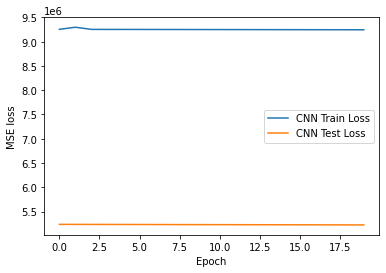

In [174]:
# faster learning rate
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_cnn_model = DNA_CNN_Multi(seq_len,lin_share_size=100)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.0001) 

epochs = 20
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

cnn_train_losses, cnn_val_losses = fit_multi(
    epochs, 
    multi_cnn_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

cnn_data_label = list(zip([cnn_train_losses,
                           cnn_val_losses], 
                          ['CNN Train Loss',
                           'CNN Test Loss']))
u.quick_loss_plot(cnn_data_label)

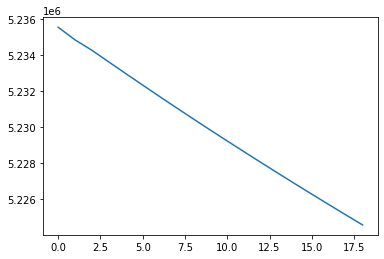

In [175]:
plt.plot(cnn_val_losses[1:])

Running CNN


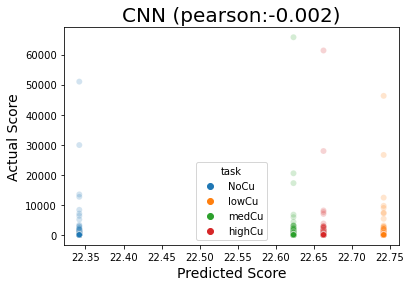

In [176]:
models = [
    #("LinearDeep",multi_lin_model),
    ("CNN",multi_cnn_model),
]

genes = test_df['locus_tag'].values
task = "cu_test"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

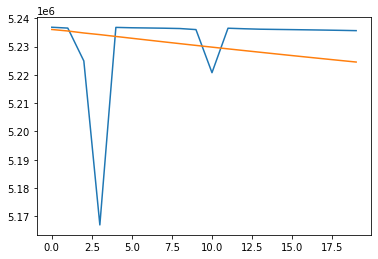

In [177]:
plt.plot(lin_val_losses,label="Lin Val")
plt.plot(cnn_val_losses,label="CNN Val")

# inspect

In [178]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2976, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
    (6): ReLU(inplace=True)
  )
  (nocu_obj): Linear(in_features=10, out_features=1, bias=True)
  (lowcu_obj): Linear(in_features=10, out_features=1, bias=True)
  (medcu_obj): Linear(in_features=10, out_features=1, bias=True)
  (highcu_obj): Linear(in_features=10, out_features=1, bias=True)
)

In [132]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    #print(model_weights[0].shape)
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    seq_len = model_weights.shape[-1]
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(seq_len))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 1


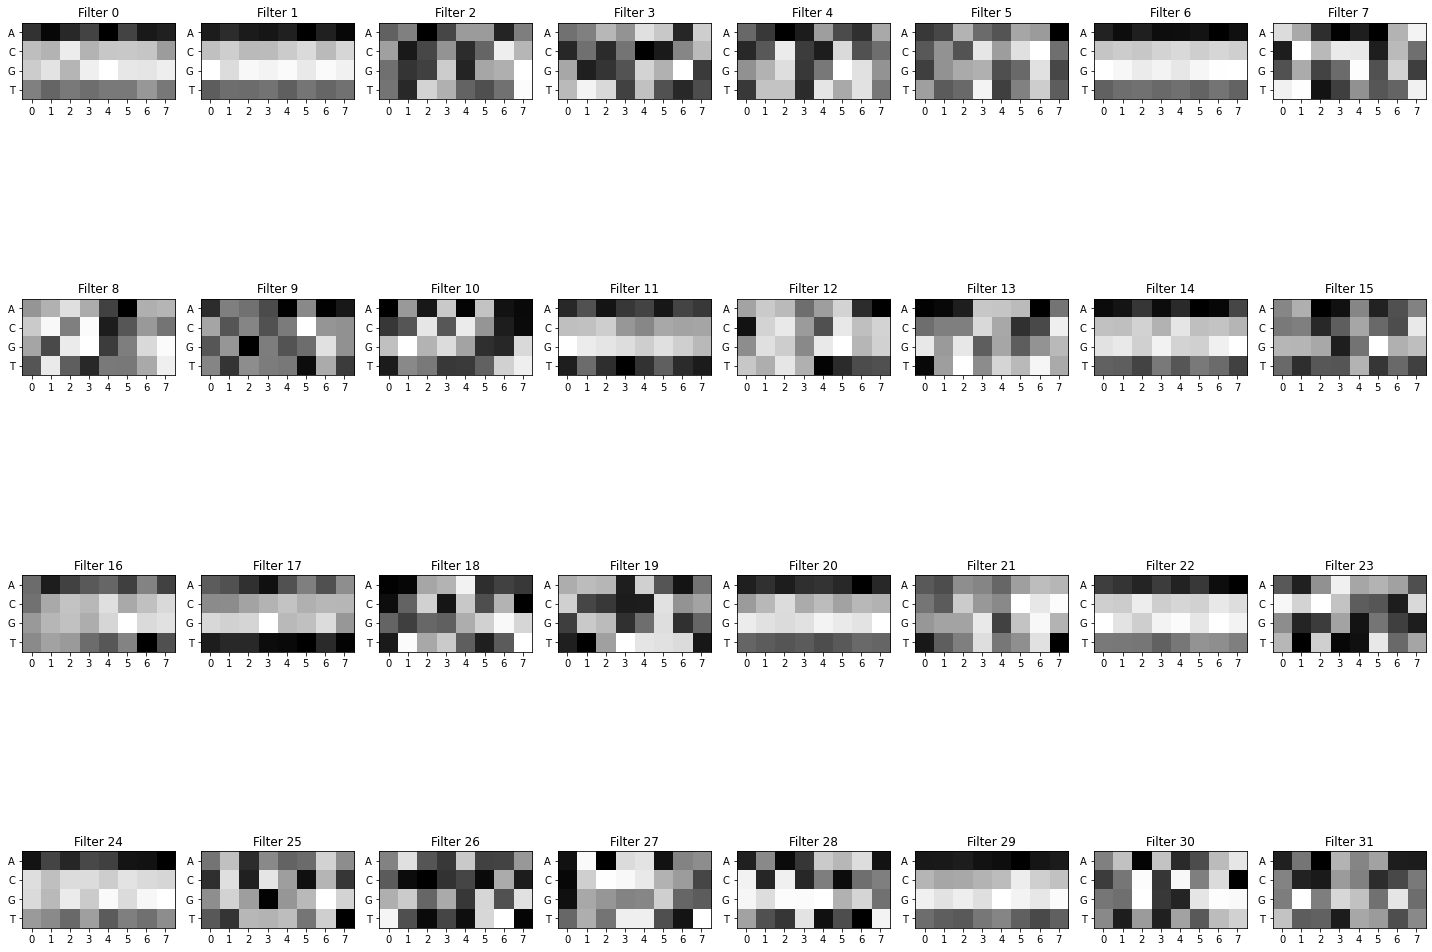

In [179]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(multi_cnn_model)
view_filters(model_weights)

In [180]:
all_seqs = XYdf['upstream_region'].values
filter_activations = get_filter_activations(all_seqs, conv_layers[0])

Num filters 32
filt_width 8
Running seq CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT
Running seq AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAAATGACTTATCACGCTTTTTTTATAGGCTAATAGTAAATATAAATAAATATCTTA
Running seq ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGTTGTTCATCTAACCGGTGTTAACCGCGTGCTTTTTTTGACTAGCAACTAATAAAC
Running seq AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAAACAAGCGTAATGTTTCACGTGAAACATTGGTACATTGAGAAGGTAGTGAACACA
Running seq CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGAGGTGCGTGGGTATAGCTCAGCATAATCAAACATACAGAGCTGAAAAAGAAGAGC
Running seq TAATCCTGTTGCCGGATGGGGAAACCGTACATAACGCATTTATCGATAGAGGGTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTATA
Running seq CAGCATAGTCACGGTAGGACGCGGTTAGGAACGAACCGCATTGATTGATACACGCCTGTTTTTTATTGCCACCAATCACTATTTGGCATAGCATAAGCCC
Running seq CACCCGTGCAACTGTAAACAGTTTATAGACCGTCGGATTCGCTGAATATCCGACTCGTTGTTTCAGTTGCGGCCCTGCTGCCGCATATTGCGGAGCTCAA
Running seq ATCCGTGCCAGAACCCAACAAGCCATCCTCAACGCCAAAGAACGTTCGGTGATCTT

Running seq CTGTGGACGGACCGTTCAAGCCCGAACATTACCGTTATTGATCGATGTAGACACAGACAAGCCATTAATTGGCTTGTCTGTTGTTTCAATACTCTGAAAT
Running seq ATCGGATTAATCAAAAAGAATCGATGGTTTATCGAGAAAAGGGCGAAAGCCCTTTTTTTGTGACCGCGCGAAGTATAACTCACAGGTCATGGGTATTTGA
Running seq GTTCGTCTGGGTTCCAGAGTCTTGCGTACCGAAACGGCAGCGTTGGCTTCGATTGCTTCTCTACAGATGCTGTGGGGCGATTTCGGAGGTAGCACACAAT
Running seq ATTACCGAAAATCTAAAACAACAAAAAAATGCCAATGCAACCCAGTCTTGAATTAAAAAGACATTCGTCTTATATTGCCCTTTTAAACCATACATTGCAC
Running seq TTCGACCACTCCCCCCCCTTTTGTTAACAGCGTATTTTTTTAAGACTCTAATCAAGCGTTATACTAACCCTATCATAGAAAGACGAAGACAAATCATAAT
Running seq TCGTCTTTCTATGATAGGGTTAGTATAACGCTTGATTAGAGTCTTAAAAAAATACGCTGTTAACAAAAGGGGGGGGAGTGGTCGAAATTTTTATTTTAAG
Running seq GATTGTCTAGCGGTTCGGAAACTATATTGAACAAGCTGATTCTAATGTCAAATATTTCATAGTATAATTTTCGGTTATTTTTCTGACTGTAAGGAGTGAG
Running seq CCTAATTATCATATGGAATAACGGTTAATCCATCCGAAAAACTCATCAAGGGCTCGTAGGAGCCCTTTTAATTTTTGTCGTTACAATATTCGAGGTTCAA
Running seq TACGATTTTTTGGATTTGGTTTCGCGTCGGATCATTAACGAAGTCTCGGGTATTTCTCGGGTGACTTACGATATTTCCGGCAAA

Running seq GCTTGTTTCGAAACACGGCATAACCGGGCCGGATCTTGGCAGTTGCCTAAACTGCTGGCACTTCGGGCCCGAATTTTCGTACACAATAAACCCGTTTGAT
Running seq GAGCGCTCTATACGAGCAGCATGGAAAATGATGATTGATGTTGCGGGCATGAAATGATTCCTTTCGCAGTATTCGCCAGTCGCTCATCCAAATCGGTAAC
Running seq GTATGGGGTGTGGTTCACGGCGGCCCTCGATAGACACATCCCATACCTTATATTTCTTCGACGGTTTTTCGATCAAAAGGGAATAAATAGCGTGAGAAAC
Running seq ACGAGTTGGAAGAAATATAGCAAAGTTTATGTTAGCGGACTTGTAAAATTAACGCATCGAGTACGAAAATATCGTGTGGCCACTAACAAATAGCAAGCAT
Running seq ACTCGTTCACATAGGAGAAAATCCGCGGCAAGTATCTTGAAGTAGTAGGACTCATAACAATATTAACAATAAGCTTTTAAGCAGTCCGGGGAGATTTAAT
Running seq CCTTCCTTAAGTTGGCGCTTATGGGGGGTCAGATAAATCTAAAAATCAACCTGACCCCTTTTTTCTGCAAATAAACAACAACGATTTTTAGGGTTCAAGC
Running seq TGTACGTTACCGTACAGAACTTATCTATTTTTTAAGCGTAAAGTCTAAAGCTGATGAGGCAAAATAGTTTATTCATTAAACACAAACCTGTTAGGGGACT
Running seq ATTGCAGACCCTGCTACCTGACTAAGCCGTCCCTGTAAATATGCGAACTATAAACCCGGGATTATTTTTAAAATCAATAGGCTCAACAAAAAGACTGCTT
Running seq ATTAAAAAAAGGGTTTGGTCGTCTTTGACCGGGCCCTTTTTTATTCCGATGTATCCATCCAATACTTTCCTATTCTTGCTTGTC

Running seq TCATCAAAATGTAACCTTGCTTATTTAGGATTAAAAAGGTCTGGCATCGACTCATTAACCTTATGCGAACTTCCTTTCAACCCGCCAGGCTAGGAGAAAA
Running seq CAAGTTCTATTAGATTGATACATTAATAGAAATGGAGCACACAAGTCCTCCCGCAGCGCAGCCTTTTCGTTTTTAATTTTAACTTCAGAACATATTTGTA
Running seq TCTTTATACATAAGTATAAATATATCTAATTGTGCAAAAAGTAGCGACCGAGCGCTAAATTACAGCAATTCCCAATTTGGAGATCAAAAAGGGTGTGGGG
Running seq ATTTTCCGGCAAGCCTGAATATATGGCCGTTCATTATTATCATACAAGGCTTGCTGATGGTTTCGACACTAAAAATATCGCGAATCTTTTGAGGCTCGCC
Running seq AACTGGGATCGGCCGGCGATGACTAAATGGTTATCGCTTCATCATCCTGTCACAATATCTTTTTACGATCGCGTATCGGGGTTAATTTCAGCGGGGCGGT
Running seq TACGCGATCGTAAAAAGATATTGTGACAGGATGATGAAGCGATAACCATTTAGTCATCGCCGGCCGATCCCAGTTAAATCGAGAACAGTCATCGATTTGT
Running seq GAGAACAGTCATCGATTTGTCATATTATCGAGCCAATATAAGATTTCGGAATCGCAACACCGCAGCAATTCCCAATTTGGAGATCAAAAAGGGTGTGGGG
Running seq AACCAGTTGCAGTAAAAGAAAGCGTCCGTCTGGCTGCAATCGAGCGGTTGAGTTTGACTGCAGTCAGCCCGATCAAATCAACCATAACAATTGAGGACAA
Running seq AAGAGGCCTTGATTTCAAGGGCCGATACGCCGGCAACCTGAACCAGGAGGCCCGCACCGATTAGTGATCGAATCATTTTTTTCA

Running seq ACCCTTCCCAATAAAAAAATAAAAAAAACAGTGCGGTACTTTATCACTTCTCCGTCTTATCAAAGACACCGTTCATTTTTCGATAAGCTTCAGGAGAAAC
Running seq GCTACAGCCTAACCCAGCTTGCAGGGCTTTTAGACTGATTTGCAGAATCATTTTCACAACTTATGGAGCTTGAGGGGAGAAGAAGCCCCTAAATTCTCAC
Running seq GGCTACATGATACGTGCTTTAACGGCAATCAAAACCGCACCGCAATTGAGTAGCCGATTATCATGAAACGACTTATTGATGACCCAGCGCCCGGCGAACG
Running seq TCAATGGCAGTATGGATCCGGGCGCAGTTAGTGGCGTGAAGTGCGTTTAAAACAAATACCGCTTATAATCTGACCAGACTGGTTAGAATTAGAGGTTGAT
Running seq AATCGGCAGTCGCTGGTTGAATTCATGCGTCGTTCGCCACTTTATGATCAGGACGATCTCATCATAGAACGCGATGCCAGTCTGACCCGTGAATTCGAAC
Running seq TATTCGATCGTAAAGCCTTATGTCGATCAGCTTGGGGCATGATTAGCAATGAGTGTTGGAATTAAACAACCCGGGTTCGACGCCCGAGTAAGGAATTCGC
Running seq GGGCTTACCTTAACTTAATGGCAGTGACGCAGAGCGTGGGAACGAAAATTGCCGGGGGACTGAATAGTTACAATAAAATAAAATTTCAGAGGATAAACGT
Running seq AGCGAATACCGCACTCCGATCGGACAATCCTTGCGTGTCGCGAAAAAACAGGCGGCACCCGAATTGCTCAAATTGCCGGTATCGGCACCGGAGACGGCAC
Running seq GATCTATTTGTTGGACGAGGAAAGCGCGGCGTTGGTGGCGAGCCGTGGAGGACAAGTTCGTGTTGTCACCGGCTGAAACGATCG

Running seq GTTTTCTGCGGGAGCGATCACCAGATTCATCTATTGGCAAACCTCGTAGCTTCAAGGTGTTATTTGTCACTAAATTGCAAGTTTAGCCAGTGTTCTTTTA
Running seq AGGCTCTATGCCAGCTCCATGCTGGCAAAGCCTTTGTCGAGCACCCCGGTGCCTCCTTAGTCACCTGCCGAATTTTGAAGTACGAAAGGTATACAACTGT
Running seq TTACTAGCGAATAGACTAAGGCGATCGTGGTTGGCTATAAACTTAGACTGTTCAATTGTTTTATCCCACCTTAAGTTAAACTTAATAAGAGAGAAAAAAA
Running seq AAAGTTGGCAATCATGATAGGCTATCGCACGTTAGTGTTGAGGCTCATTCGCTAGAATCTCGAATATTCTTTATTTATATTGTAAGGGTAACTCAAAGAT
Running seq ATAAATAAAGAATATTCGAGATTCTAGCGAATGAGCCTCAACACTAACGTGCGATAGCCTATCATGATTGCCAACTTTTTCGAATCAGTTACAATCGCCT
Running seq CTTACAGGGATGTATTCACGCGTCCTTAGAAATCAATGCCTGACACCAACCTACCGCATGCGCTGAATAGTTACCTTAATTTAAATCACAAACACATCGG
Running seq TCCTTGTGACAAGACTTCGGTAGTCTATGCCGGAATGACACGGCCTTAAAAAGTTGTGTTGATACTCACATCATGACATTTATCTAAAGAGAGCATTTCC
Running seq CTATGTATGACTGCGTGTATACCCATCGTAGATCAAACCCTAAGCACTCCCGACATTTGAAGTGCGAAACGAATATTTTCAACGCTGAATCGAGGGATTG
Running seq TGCGAACCCAAAAGTCCAGCACGGAAGCCCCTCAAACGGCACACGCCTATCGGGTCTATCCGGAAATTTTACTCTAAATACTCT

Running seq TTTCGCTCGGATGGGCGTAATTTTAATTAACTCTCTTTTACCCTGCTAAACCGGTTAAAATGGGCGGTTTTTTACAACACTTATACATCCGGAACAAAAT
Running seq CTGAGCGAGGCATTCGACTTAAAAGCCACCGGCACGGCTACCGACGATATTCGCGATGCGCTACAAAAAGCCGCCTAATGAATCAAGTAACGGAGGTAAT
Running seq CCCGCATAAAAATCCTCTTGATGTAAGTCAAGGACACTGTAATAGCTGAGCGCTTATCCTGGCAACCACTTCAATTCACCAACGTCCAATCAGGAGAAAT
Running seq AAAACATAATTTCTCCTGATTGGACGTTGGTGAATTGAAGTGGTTGCCAGGATAAGCGCTCAGCTATTACAGTGTCCTTGACTTACATCAAGAGGATTTT
Running seq GCATTGGATGCCCTAATAGGCTTAATTATGTTTGGCGTTGGGTTAAACTTAAGCGCAGTTTGTGTTGGTTTTTGGAGAATTCGACGATGTTGACTAAAGG
Running seq CCTATGAATATACTAGGTTATTATTTATTTACCCTACTCATAGAAAGGCCTTTCCATGCTACAATGCTCGCCTCTAAAAACGACCCCAAAAGGTTTCAAT
Running seq AGGGTAAAGTGGATCGGTATAATTCTAGCGTTAGAGTCGCTTGAGATAGTTGTTCGTGAATGAGAGAATAAAGGCTATATCCAGCTGAAGTGAGTACGAT
Running seq TGCGCGAGCCTGAGAGGATTTATTTTGCGGCGCAACCCTTTGCACTCGGTATCATCGAGGCAATAGAACATTATGATTTTTAAGTGACTGAGAGCAGAAT
Running seq GGCCGAAGGCGATTATCTCGGCATGAACGGTAATTACAGTGCCGGTATTTTAGAAGGCGTTGTGCATTATTTACCCGAAATCAA

Running seq AACTTAAAGGCCGTGACGCTCTGCGGGGGAATGATAGAAAATCGGAAAGTTATTTGCACCCACATCCTAAGATCCTGTCTAATTTAATGAGAGGTCAACA
Running seq TAGGATGAAAGCTTTAGTTTGAGATTTGTACTATTATTTAACGCGCAAAATAGCTAACGCAGATAATTAGCCGTTTATAAATTGAGAGGATAAGGATGAG
Running seq CCTCGTTACGTTCTGCCATTAAGAGATTTCACTATTTCTTAGCTAGACGGTCCGCTTTATGGACTAAATTGATTTAAATTTTTATTTTTAAGGTTTTGAG
Running seq CAAAACAGCTACCGTCTAGATTCAATCGCCTTATAGGGTGGGTATTTCTTTAATAGTCACTGAATTCACTAGAAAATTTCTATATAATCGTTTTAAACTG
Running seq TTTATTTAGATAAATTATAAGTGCATTTAGAGTCAAAGCCTTAAAAACGGACGAAACGATTTAGGAGACGAATCGTTGTTTAATTATTCCCTGGAGCAAC
Running seq ATTCTGCGCGTCAGGAATCTGGCCAAATCGGTCGCCGAATGTTATTACCAACGCCGCGAGTCGCTGGGCTTTCCGATGTTGGCCGCAAAGGAGGTGCAAG
Running seq CTGCAATCGTAATTCGGAGAGATTGCCGCTCGTGCCGATTTTCTCACTGTACCGGCTCGAGCGGTTTTTAATCCTCCGTGATCTTTAGAACGTTTTCATT
Running seq GCTGGCGATATCAATGCCGAAGCCGAAGCTTGGATCGAACAAGCCATGACCGAAATCTCTCACTTGCCCCAGACTCCGGCAACTCATTATCAGGTAATCG
Running seq ACCCTTTGGTTAAGCTCCTGGCTTAGGTTTCAAGAAGCTGGAGCTTCTTGTAATGCATTCCCAAGCAAGAGCTTGGGAACGAGT

Running seq AAATTCGGTTTATCTCGAAATAAATTAAGAGAATCGACCATGCGTGGTGATGTGCCTGGTTTGGTTAAGGCGAGTTGGTAAGATCTGTTTGGAGAATTGA
Running seq TCGTTTCGACATCGAAAGGTGTCATGACTGACAGAGCGGCACGTGCGATAGGGCATGGCGGTGAAGTTGTTTGTACTGTTTGTTAATTAGGGAGCCAAGT
Running seq TTAGAGCGTATCGTCCGCCGGAGCCTTATAAAGGTAAAGGTGTTAGATATGCTGATGAGAATGTAGTCAGAAAAGAAGCCAAGAAGAAGTAAGGTAAAGT
Running seq TGAAGTGGCTTTTGACCGCTCAGGTTTTAAATATCATGGGCGTGTTAAAGCGCTTGCTGATGCCGCGCGTGAAGCCGGTTTAAAATTTTAGGAGATTTAT
Running seq GTTGTTAGAGCGACGATTGCCGGGTTAACTGAAATGCATGAGCCAAAAGACATCGCAGCCAAGCGCGGCCTGTCTGTTGAGCAGATAATCGGATAGTTGT
Running seq GGTTTACGTCGTATTAATCATACGGTATCGGTTATCGATACCCCTGAAAATCGTGGGATGATTAATAAAGTTTCCTACATGCTAAAGGTAGAGGAATTGT
Running seq CTGTTACTTTGAAAGGTATAAAAGTGACTGCAGGCGCAAAAGTATCTATTGAAGCGGCTGGCGGCAAAGTAGAGGTCTAAGTGAATACAACAAGAGCACA
Running seq CTCAGATGCAGACGCATATGATGTCGCAGCAATACGAAGGCTTGATGAAAAAAGCGCATCTTAAAAAATAAATAAGTATTTCAAGTATTACGGAGTGCAT
Running seq GCCATAAGCAACGTCAAGGATAATTTTCTATTGCGCCATAAATCATAAAATGTTATTATTCGGCGCTTAACTTTAGAGTCATTG

Running seq TGTCGACGGCAATATTCGTTTGATTTTGTTGAAAAGCATCGGCGAGGCAACCTTGCCGGTCGGTGTCGAAAAAGCATTATTGGTAGCGACGCTAAACGGA
Running seq GCATACAGTTATTTTTGGCGATATTCTTAAGCTTTGGATGGGGTCGATAGTAAATTTCAAGGCGATTCGCGCTTATTCCTTAAACAAGAAAATAAAACAT
Running seq GGAAGTTATCTACGTCTAAATCCTTGCACTGTCTCTCCAGCGAGGAAACGCATATGAGCCGAATTTATAATCAAGTAAATTTTAAAATCAGGACTTAAAC
Running seq GAATTAACATACATAAATAAACATAGCTTACCTTTACACTCAAGCTTCGCCAATTTCCGCCGATAAAATAATTAACATTCCCGATCTTTAAGGATAGAGC
Running seq TTAAAGATCGGGAATGTTAATTATTTTATCGGCGGAAATTGGCGAAGCTTGAGTGTAAAGGTAAGCTATGTTTATTTATGTATGTTAATTCGGAGTGATC
Running seq AATATAGGGGCTGAATAATTACTTCGTTTATTGTACAGATCGTCATAAAGCAGTGGGATAAGAGTCGGCTAAGCGAGACGGATTTTCTGGAACGGGCCGC
Running seq AACTTAATGGCAGTAGGTTATCAAGCGCTAGGCCGATAACAATGGCGTATGCCGTGCCTACCGTATTTACTTTAATTTTTAAATTAGCTATTCAATTCAT
Running seq TCGTTCGGCTCAATGTCGAATCGCGCGGGGATATTGCGTTGATGCGGCAAAAAACCGAGGAGATTTTGGAACTGTTACAGCGTGAATATTGAGGATTGTT
Running seq CGAATCGGTCATTTCAGCGGTGCGCGACAAAGTCGCCATCTTGTGCTCGCGCTTTCCGGTTTACGGCTAATTGAGGACACATCA

Running seq AAAACCACAGCGGTAAGATTGAGGTAGAATCCTACATCGGCAAAGGCAGTAAATTCAGAATATGTTTACCGCTGACTTCCAATGGGTGCTAATGCGGCAC
Running seq CCCCTATTTTTAATGCAAGGCAAGCAGGTTCGGTAACTCGCTACAAAACTCATAGCTCCAGGAAGTTATTTTTCACGAAATCCTTAACCGACTCGAATAA
Running seq TCGTTTGGCGTAGACTGGCGTAAGTGTATGGGCAGCAATTCGTTTTGCGAATGGCGGCTATACTGGATGTTTTATTCATCGGTCGATTTTTTCCTAAGGT
Running seq TAGTTCGGCGTTGACCGGCGAGGGCATCATCGAGACCTTCAAGGCTTTGTTGGCGGCTGTTTATCTAACCTGCGATCGGCTGTACCGCTTGCAATCGGAT
Running seq GGCGGCTCGATCGATATCGTGAGCCAGATAGGTAAGGGAACTCGGGTAACGGTTAACTTACCTGTGCATAACGCCATTCAGAACCCTAAAGAGTCTTAAC
Running seq AAAGGTTGCTAAAAGATTATGAATATCATCTTGAAATACCTCACGAACTTCATGTGCTTCATGGTTAAATTGCCGAATTTAGGTCTCTTAGGAGTTTATT
Running seq CCTACATGGACGTATTCACGGCGTCCTTTGACGAACCCCCCGGTGCCGAAATTTGACCAGCAAAGGGTATACAAGAAACTAAAGCAAGTTTTGGAGACGC
Running seq ACGTGTAATAACTTATTGAATTAACCTCCTATTCTTCATGGTGAAATGCTTTTTCTAGGATAATAACAACAAAACTCTAAGATTAACCGAGGAGCCTAAT
Running seq GTTCCTCGACAGGCATACCCCACACCCTAAAATCGGCGAAACTGCTCAAACTGGGAATTGCTGCTAATTTTGCCTAACCCCTTC

Running seq CCAAGTTGAAACGAATCAATAAAGCCCCGCCGGCCGGGATGAAACAGCCGATCAAATTTCGAATTACGAACCGCATTTAACTTCAGTTAATGGGAAAGAC
Running seq TTAAGGTTGTGGTGAGCCGTGAAATCTATAGAAGAGGCGAGCCAATGTTTGTCCTGTCCGGACGGCCAATTGTGATCAATTTCCGAATATCATCAAATCT
Running seq TGACAGGGGTTTCGATATCTTAATGGCAGTGCAAGCTAGAGCTTGGGAAGGAGCAAAAACTTATACCAATTATCTCTCCAAACCGCTTCCGCACTAGGAG
Running seq CGAAAAACCTTTTTCGACAATGATGGTCGAAATGAAACACTTACTCCAAAAATCTTACTTTGCGAGTCCGAAACCCTAACAACATATTCGAGTAAATTAT
Running seq AATACTTACAAATCAATTTATTTTCCGAGTCTATAATGTCGGTTTTACGGGAATCACTCAGAATTTCTCAAAGTCAGTCATTTCAAGTCAGGAATAAGGC
Running seq CGGGAAATAAATTTACCATGTGTTTCATGGTTAAACTGCCTAATTTACTGTGAAAGTTCGTAGATTGAGACTCTTTATCTAATTTTTCGATATGTAACAC
Running seq AATTTGCTTGGGTTAGCGAGGAGGCACTTTCATAGTAAAATGAATTAGGCGTTAAAAAAAAGGTCTGAAACTAGCATCAATAAACACCGTGAGCCCAGGC
Running seq AGCTCAATATTCAAATACGACTCTCGCGTTGGAATCGTGTCGAATGATGGCTTTTCCATGCTGTTTTTATCAAATTGTTTAATCGACTAGGATCAATTGC
Running seq GACGGCGGCTATTCCGGCCGCCGACACCTGTCAAGCGAGCCACCGAACCCCTTCCAACAGTTATCGAAGTTATTTCATGCTCGT

Running seq TTGCGGTCGCCCCGATCGAAGGTTTTTTACATCCGAAAACCGAATTGGATACGCTGGGTTTTGATCAACCTGAAACCAAATTTAAGTAAAAGGTAGAGAC
Running seq AACGGCGTCAGCAACGATATTTCGATCATCGACTTGGCTAGTCATAAAGTCACCAAATCGGTCGGGGTAGGGCGCTATCCCTGGGGAGTGGTTGCTAAAC
Running seq GGCCAAGTCAAGGCGAACGGCGCGATTCCTAAGGTTTTGCAACAGACCGGCAAAGAGTCGATCGACGAGGCGTTTTTTGCACTGACTCAAGGAGCGCGGG
Running seq TTTATCTACACACTATCGGCCTTTGTCATTTTCATGACAGCGGCCATACTCGGTTATAACCCATCGAAAGGCATGATGACTCGAAAAGGAGGAGGCGCCT
Running seq CGAAAAACCGTGCAATGGTATCTCGATAATAAAGCCTGGTGGGCCAATGTCTTGGACGGCAGTTACCGGGGCGAGAGACTGGGGTTGCAGAATCTTTGAA
Running seq TAGAGTACGCGCCGCGTAAACCTTTCGGGCTACTCCTTTATACTCAAAAATTGACTAACTTTTTTAGTCTTAGACGGTTTTTCAATCAAAAGGGAGTAAG
Running seq AGCATGATCAAGGAAATCGCGCGCCTCAATGGCGACGTATCCAGCTTCGTGCCCGATATCGTTAAACAAAGTTTGATCAAGAAATTTAGTCAGGAGTAAC
Running seq TTGATCTCCAATTTGGGAATTGCTGGGGAAAACACAAACAGATGAAAAAATCCCCTTAAAACGTTATAATCCGCTACTTTTTTCATCGTTTTGGCTTAAT
Running seq TGTCAGCGCACTGGTTACTCCTTGGCTCGACATTTATATCGAGCTTTTATCCTCACAGATTCTTTGTTAAAACCGACAAGGAAA

Running seq TTTAAGAATTCGCTTTGGGAGTAGCAATAAATGTCTATTAGGCTCTAAACTATTTTCCGCCAAACAAAGTAACTAAAATTTCCTATGAAGGTTTAGCGAC
Running seq GAATGTAATCGTTTAGCCCCCCATCACTAAAAAAGTAGCATCTCCCGTTAAAACATGAAAAGCTATAGGACATGACGTTGAGCGACCGAGACCTTAGCCA
Running seq CGAACGCCGTAAAAACCAACCCGTCCCTCGTTTGCCTATGCCGGTTTTGGCGTGATAGGAACAGGGGGGGGCTAAACGATTACGAGCGAATTCTGACCGA
Running seq GTAAGAGCCTTTTTCGGCATGAGACAAAACCGAGTTATTTTCGATGCACCATTAGAAAAGGCGCGTGTCAGATTTATTTTCAAATCTAGAGTTTAATTGG
Running seq TCCTTTTTCTAAATGGGTATAATTTTTAATAGTTGTATTCCGTATAGACTTCGCGCGAAGTATGGTTTATGTGCGGATTTATTAAGAGGTAGTGTTTAGA
Running seq GAATAGTCGGTAAAACAGAGTATTATTAATGGAAAAAACATGATGAAATTGATCCGAGGATATCTGGCATGCTACGGAATGATGAGATATTGGAGTAATT
Running seq TTAAGAAATTGGAGTCCTGCGATGTGGTTCTTGCTTTGTTGAACAAAACGCAAAGGAGCATGGATATGAACTACTACGGATACGGGCAGTATTGATTTTT
Running seq ATAGTTTCGACGAGAATCGCATTACACTGAATTTGATGGCGTTTTTCTAAATTTAAGGGTAACTGGATCTTTCAATGGAGAATAATAAAATAACGAATGC
Running seq TCAATCTGCTCCACGATTTTTCTTGGGATACGATGTCGAACGTTTTTCTCAATATCGATAAAGGCCGATGAGCCGCTCTTATTC

Running seq ACGCCGGAGCGTAGGAACGATAGGGGGTGTGAATAATTACAGCCAGGCAGATAATATATATTACAAGATAGATAACTTCATATTAATTATGGGCTTATAA
Running seq TCAAAAAAATAGAGGACTTCCATGTGCAAGGTTTTATCTATATTTTTAACAAGGCATAAAACCACCTAACGTTCGTGAAGCCCTGGCAATCGCCCCGGCA
Running seq CATGTTCGAATATCCTAACTGGGCCGCCAAATTTTTTGCGGATGCACTTATGACACGAATCTCGGGCGAACCGATTCCCGAAACGGCCAGGAGCTAAAGA
Running seq TCCGGATATCGGCAATCCATGCCGGCATGACAACTTAACTTAAAGGCAGTGAAGTAAAGTGTGGAAACAACTGTTCAATTTGAAAGAATAATAAGAAAGC
Running seq GCAAAGAGGATCTGAATACTTACTTTTAAAACTCTCTTGGTCACTGATTTCTTTATGCTACCTTTAAACCAGACCGCCACATTTTTCTAATAATACTAAC
Running seq CAAATGGTCTTAGGCGAACAGCGCCTGGATATTCTCGTTAAAGACATCGATACCGCAAATTTGCCAATACATGATGTGGCCAAGAAGCAGGGAATAAGAT
Running seq TCAGGCTTCGACTTGGCTCAGCACGAACGGTCTACAACACTTGCCAACTGCTCTTTTTAGGATAAAAGAGGTTAAGCCCCTGAAAAGCTAGAGTTTATGA
Running seq GGCGACTTTGGTGAGCTTTTGCATCCCGCTTGAGAGAATGAGCAAGACGATGTCCCCAGCTGGCAAGGCTATTTATGAACTTTCATCAGGAGTTTATGCC
Running seq CTACCGAACAAAATAGCATTGCCATAAAAGCCGAAAATATGACCGTGCAAAGTATATGCTAAACTTCGCCATAACAACTCGCAT

Running seq GAAAACAGCGAAAAACAGAACTTGAAGCCTAGTTATTGATGTATGATTAGCAATCAAGATTGACGCCAATTATAAATATTTAATGTTAGGAAGATGTAAT
Running seq GACCGTAATCGTTTAGCCCCCCATCACTAAAAAAGTAGCATCTCCCGTTAAAACATGAAAAGCTATAGGACATGACGTTGAGCGACCGAGACCTTAGCCA
Running seq TTAAGTTCAAGTAAAGAAAAAAAATCTAAAGGTTTAATGCAAACTCTTTCAAGCGATGATGATGACGATGACGAAGGTTGTTTAATCTGTATGTTGTAAA
Running seq TCGGTGTCGTTTACCGAACGCTGCGACCCGAAAATAACCCTATTGCCGCTATTACAATACGGCAACGATACTTGGCTTTAAAATGCACAAAGGAGGCTGG
Running seq TATGCATTGTTAACCCTGTTAGAGCCGATAAATTATGAATCGGCGCTTTTATCGGAGCAAGCCTTATCGGAAGATTGGCTGAAACCAGAGGAGGATGAAG
Running seq AGTTTATTTTCCGGCATTGTCGGCAAACTGGGCGAAGAAAAGTTAAATGAAATTAAAAGTGCGGTTATTTCATTGCTGCAAAACACCAACGATACCTCGC
Running seq CCAAAATTAACCAACATTATTTTAGCCCACACGCATTAGATGCTATACCTGTCACCTCTTGGGTTTCAACAAAAACAGCACTTTGTTAACACGGATTTTT
Running seq TGGTCGCGATATTACGTCAGCACATTAGCGCGTTAAATTTACCCACTGATACGGTAAAGCAGGCATTGGTAGAGTTGTTGCGCGATTACGAGGCTTAATT
Running seq CATTCCGGGGCTAACGAGCAGCTTATTAAGTTTATTGATGTTAATTTTCCGGCATCTTTATTAAAAAAAGATGGGGGCGTACAA

Running seq ATGGATTAAACGTAATAGTCTACAATGCATCATTTACATAATTCACAGGAACGCGAAGTATGCGGTAGCGTTGCTGTCTGACGAGAATTTTAGTTGGCAC
Running seq AATAGTTACGCAAGATGGGCGCGCAGATTTTGTCCGGTTTATTCGGCCTGAGCGATTCAAGTTTAAAAAATCTATAGTTCTACAAAGAGGCGTTAATCGA
Running seq GCTGCCGATTTGTCCGAATTTGTCGGATGAAAACATCGAAACCATCGTCGGCGTGATTCGTTCCGTGCTAACGGCTTGATCAATCGCTGAGAGACCTGCT
Running seq CATGACTACTGTGTTATACCCATCGTAGATGAAAATTCGGCCTCGGGGAGCCTATTTTGATCTGCGGGCATAAATTCGGTAAAAAGCTAGGAGTAGAGGA
Running seq GGAAGAATCGGCATTGCTAGTCATCGCCTTTCGATTAAGCGGTAACAGCCATCGCTAAAAAGGGCTTATTATGACATAGCGTATTTTATTTGGCACAGCT
Running seq TATGAAATGTACTTTTGGAAAGAAACAGCGAACGCCTAACAGAAGACATTTTGCGCAGAGTGTTTTCGAAATAGAAACTAGTTTAGATGAGGGCAATATA
Running seq GGCTTTTGGAGGACTGCGAGCACCGGCCGAGAAGAGTGGCGAAGAGGTTTTTTCGGAAGAATAAAGTCGAGTATAAATTAAGGTAGGTGCTTTTATTCGA
Running seq ACGAGGGTTTTCCGGTGGCATGATCGCTGCTTTGCTCGAACACTTGAACATCAAAATTAAGTAATTCCAAGAACATTTAGTATTCAAAGATGATGAAAAA
Running seq AAGCGGGAGGTAATAATCCGGCGGCATTGCCGGAGGCGCTCAACTCGGTTGCGCAATGGGTTCGGGAACAACTCGGTGCTTATT

Running seq AATTTTGATCTACGATGAGTAAATAGTATTAATTGTTAATTTAAGTTCGAGTTAACATAAACAATCGAGAATCCGAACTTGTGTAAATTTACGAAGGTTT
Running seq CTACTTACCTGTCGAAGTCTGCGAATTAGTCTTGAAAAGTAACCTGACCCCTTTTCTTCTTGGTATAGGATGGTTGTTTGTCGACAATTAAAGAGGTACT
Running seq GAAGAAGATCGAAAATTAAACAAGCAACACGCCGATCGCCTTACAAGCCTTGTTAAAAACTACCGATTCGATGAACTCATTACTTGCCTTGAAGAAATGC
Running seq CAAGCCCCCATGGATGGGTTTACGGCGTTCCTCGACAGGCATACCCCACACCCTAAGATCGGCGAAAATGCCCAAACCGGGAACTGCTGGAGCTTTGTTG
Running seq AAATGACGTAACGCGGGTGAGCATCCGCCTAATGGTTAAACGAAGCGCTTTGCCGGACACTGTCAGCGAACCAAACAAAATTTAATTTGGAGAGCTTAAA
Running seq TGACTCCGGCACGCGCCGTCAACATTTGAAACCTCTCTCCCGGTATTTGAGGGAGAGAGGCAATTTAAAAAAATCCGACCGTTAGCAAAGAGGATCGAGT
Running seq TATGGCCAAGGTCATCACGCTTTTGATTGTCGTCGGCATACTGATGCTGCGTCCTCAAGGGCTTTTTGCTCTCAAAATTCGTCAATAAGGGGGAGTTTCC
Running seq CTTGGAAGAGAAAAATAGAGTGGTTTCAAAACCTATCTCTAAACCCGAAACTGTCGGGACAATGGCGCCAAGTTCCGATGAAAAGTTGGAAGGAGGCGTA
Running seq GCAAAGTGCTGTCCGAAGGTTCGATGGAGCGAGTCAAAAACGATCCCAAAGTTATCGAAGTCTATCTCGGCCATTAATCGGTCG

Running seq AGCTTCTCGCATTGCACTTCCGTGCAAAGAGTTTGGAAATTAGCGAAAACACCTCATTCAATAACAACGAAATACGCTACAAAACCCGCCGCACACAACT
Running seq CCTTAATGGAGTTTATCGAGCTATATAAAAACCGCCTTAAAGCGGATAAAACCCTACCTAGCCTAGATGAACTGCTATATAGCGAATTATAAACCCAACC
Running seq ATCAAGTATTTTGCTGAACGTTGATTCTTAACGCTCCCCGAACAAGGTACGCGATGCGTGCCCTAAAAGCTTTTTAACTCTTAACCAACCACACCTCGAC
Running seq ATTTTGAATACTTTCACAGTATCAGGACCGTGGGAACCAAAAATCCGCCCCAAGAAAATACCCGCTTCTTGAATGACTGCGATTAAAACGGTAAATCACT
Running seq GAATCACGTCAGGATCGCCTTAGTAGCACCGATCTACGAATGTATCGATGCTGCAAGGCGCATTAAAAATTTCATTCACACGTTATAACAAATGGAAAAT
Running seq CATGCCACTCGAATTCAAGAACTGCAAAATGCCATACCAAGAGCATTAGAAATTCAAAAACAAGCAGCCGCTCAAGGCAAACAACCTCGTTGCAGTAAAT
Running seq ACCGAAATTTGACTTGTCTGATTAGAGTATGTTCTCGCCGATAATCGCATAAGTATTCCTGATCAACCTAACGTCTTCAATTCGGCAAAGGGTACCGCAT
Running seq TCGGGTTAAAATGCCTGCCATTGCTGCAGTGTCGGTTCGCGTTATTCGTTTAATCGGCATGGCTAAATCCAAATCAATTTAAGATAAAAGAGGAAAAGCG
Running seq TGCGCCTCAGCGCCTTGGCGCGATAATGATACAATTCAACCTAATAATCCGATGTCTATGTGCTTCGATGTACTGCTCATCTCT

Running seq CAACCTATCAAGGGCGAAAATCGGGTCAGGTAGTAATTTGTGCGTTTTATCGTCTCAGTTTAGGAGTCTTGGTCATCAGGCTTATATTGACAGGTTTTAA
Running seq CGCGCCAACCGCAGTCGAAACGCTGCCTGAACATCTAAAATCGGTCTACAATCCGCAGCGTAACTCTAAAATATTGTGCAAATCCATCTGAATTAATACC
Running seq GTTCGGCTTCAAAAGGTGCCGTAACCGACAATTTAGATTGATCGAGGAAAACCGACCGAGTCAGCTTTTTTGTGACAAATTCGAATTTACCGGCCCCGTC
Running seq AAGTTATCGCGAAATCCTAAGTTATTTTACTCATTCCTAAGGAACCGCTTCAGCTTGATACCCCAATCCACTATTAACAATTGAACACATCAGGAATTCA
Running seq TTCCCCGAAGCGGAAAATCGCCTGCACGCACAAAAGGCTTTGCTGGAATTATTAATGAGTGACAAGTAAAATTCGACCTATTCCTATACAATAATGCAAC
Running seq AAGGTTATTACCGCCGTTGATTATCGACGAGCAACAAATCGAAAGACTGGTGGAAACACTAACCGCCGTCATCCAAGAATTCACGGAAAAACATCAAGCC
Running seq TAGCATTACTCTTGATTAGCCTGATTATCAAACATATAATCATCGGTTTTCTTCTAGGCGGCTTTTAGCCGCCTTTTTGCATTTTAGGTAAGGTGTAATC
Running seq GATAATCAGGCTAATCAAGAGTAATGCTATAAAAAGAAGCTTTTTTATCCGGTCTAATCTTGATAGTATTACTAGGTTTTTATCATTAACGGGTAATTTT
Running seq GTTTTTCGCGTAACATACCACAATATCCCTGCCCTTTCGAGCATTGGCAATAAACTTGCCGCTACTCCTTTTTTCAAATTTTTC

Running seq GGAAGCAATGCGGCGGATCGCGTTGGAAATTTTTGTTCTTCCGGAAAAAACTACAAACGGAAGTCGAAGCACTGCTACAAAGAATCTAACCGAATTGCGT
Running seq GGTTTAGACAATATTAACCATCTACAAAACGGTATTCAGCCTTGGATTCAAGCCGGCTATGCCACCACTCAACATTGCCCCGGTCTATTGGCTTGTAAAC
Running seq ATACACTTCAAAGCTTTAACTCCGGCGATGATTAACACTGCGTATCTGGAAAGCATCGACTGGGCGAATCAAATCATGAACAACATCGAATAACCGATTC
Running seq TACAATACAACCAAATACAATGCTTTCATACTTTGTTTTATACTCGAATTTTGGCGCCGGTTTAAAGAAGCACCGGGATATTCAGCAATGGGCATATCTA
Running seq CTATTTTTTTGAATTAGTTTATATCATGTTTAACAAATATGCGTCGAGCGGTGCATAGTGCGTTTTAATTTAATATTATGACTAGAATCAGTGGAGAGGA
Running seq GAAAGGTGAAAGATGAAAGGTGCTTTGCCCCTTAAGCTCCTTGCCCCTTGCACCTTAAGCCTTGCCCCTTTAACCTTATTCACTTCTATTCGGAGATTAT
Running seq TTATTGAACCCGATGATTGCTGGTGCCGCGATGGCAATGTCGTCGGTCACTGTTGTGATGAATGCCAACCGGCTTCGGTGGGTGAAATTAGGAGGAAGGT
Running seq AGTTGAATTCGACGGCACATTTTTTATGTCGTTCACCCTATGCGGAGCCATAATATTCAGGTTATAGAGGTGTTTATGTCATGGTTTGATTGGTAAGTCC
Running seq TTTTCACTAAGCAACTTGTTCGTTGAAACTTTGATGGTATTCTTTTGAGGTAAGCTTTATTTGACCACTCTCCGTTTAACCCTT

Running seq GAGAGCCTCTATTTTGTTTCTAAGGGAGATGGCACGCATGCTTTTTCCGCCAATCTTGACGAACACAACAAGGCTGTAACCACTTATCAATTAAAACAAT
Running seq TGGCCGATCACCCAAATTGATGGCAAGCCATTTGCTGTCGGCCCTGTAACCCGCGAAATAACGGACTGGCTAGAACAATACAAGAAAAAATGGCTCCAAG
Running seq GAATGTCGCTTTGTCGAATTCTTTCGGCTTTGGCGGAACTAACGGTACGTTGATTTTTAAGCGATTCGAATAATTATCTCGATACCATAGGCGAGGCTCC
Running seq CCGAAAATATAACCGTTCGAAGTATGTAAGTGGATGCTGTTAATATCCACTTATGCATGCCTAAATATCCCCTCTTTAAAATTAACTTCGGGTATAAAAC
Running seq CGTCTGGAATGAGATGACGGGATTTCTAAGTAAAACAAATAACTATACTATTGTAAGTATTATGATTTAAAAATAATCTTACATTGTTGAGGATAATAAT
Running seq GGGTAAGGTTCTCATTGGCTTGAATAAACGAATTGCCAAGAATGCCGAACATTTAAGCATCTATGATCCTGACTCATTAAATCAAGCCTTGGAGATAGTG
Running seq AGAGACGGGCGAATTCAGCGCGGTCAAGTGCTCTTATTGGAGGCTTTCGGAGCAGGGTTTACGTGGGGTTCCGCTTTAATCAAATACTAGAGAATAAATG
Running seq TTTAAAACGGCCGTGCAATTAGCGGAAATAGAAGTTTCCAAAGGCGTCATTAGAAAGATAGGCGAGCAGGTCGAAACCATATTATCGAAAAGAGAGAGTT
Running seq GAAGACTAAGTTAAGTCGATTTCTTTTATATCAAGATGCTCAACCGAACCGGATTTATCCGGCTCGGTTGAGCATCTTATTTTT

Running seq TATGTCGTTAAAGACGGCGATGTCATGCATTTTCGTTTCAACGTTTGACAAACCAAGAGCGGGTCTCTATAATGCCCGCTCTTTTGCAAGACCTCTTCAA
Running seq CGGTGAATGTTGTTTCATCAATTCGTTCGAAAATTGTATAATTTGCGGCTTTTTATCATCAAAGCAACTATCCCAATTGCTTAAACACTTCAGAGACCTC
Running seq TGCAGGAGCAAAAATCTGCCCTGCTGCCGCCATCCTCGCCAAGCATACCCCACACCCTTTTTGATCTCCAAATTGGGAATTGCTGCCATCGTTGTTATTG
Running seq TGCTCAAACTGGGAATTGCTGCAACGATGGTTTGATATTTTTCAAGCATTAAACAGACAGATGTATAATCGGAAACTTTCAATCAACTCTAGCGATAATT
Running seq CATACAGGTGTCGGCAGCAGGGGGCCGCCGACAAATGCGGAATTTCCTACTTGGGCAACTTGAATTTAAACTGTAAATCTTTGATGGGAACTTGAACTCG
Running seq TCCTGATTTTCACACCCGAATTGCCCGATTCCAGACCATCGCTGGCGTAATGCAAAATTCGCATTCACCGATATCCTTTCAAAAACATACAGATCACACC
Running seq AAATGTAGGATACGCTACCGGGCTGGGGTGATGGGTTTAAAAAAAACCGAATTTTGATGTGCGAACACTATACTTAAAACACCATTAACTTGGAGAGTAT
Running seq TAAGGCGACCTCGATCGCTGCGGATTAAAAGGTAATACAAATTACCGTTTAATTTAGGTATGATCGTCGTTCTTGTCAATGTATTTTATGAGTAAGACAG
Running seq GTCTTACTCATAAAATACATTGACAAGAACGACGATCATACCTAAATTAAACGGTAATTTGTATTACCTTTTAATCCGCAGCGA

Running seq AGGAATCCGAAAAGTTGCTTGAATCCAGTCAAATCAATACATTAGTCAAGGATATTTAAGTAGTAAAAACGTTTTCCTGGCAATCTTGTCGTCTTTTGAC
Running seq GACTGCTATAATTTTATATATAGTAATTTAGATGAAGCAGTAGTGTTATTCGACCAGTTACTTGAATAATACATGCTTTTACTTTTTCTATTTAAATTTC
Running seq ATGACTGTACCCGACCTATTTGATGAATTATTCTTAGATCGAAGCGATGATGACTGTGTTGATTTTATTCACCGCTCATTAAAACAGTTATTTGAGCTTG
Running seq AATGAAACCTCATAAGACACATTGTACTAATGTGCAATGGACAAAAGCGGTTCTTGTTGTTAATGTTTCAACAATTTAAATTTTTTGAGCGAGGCTTCCA
Running seq AAAATCCATAAAGCAGTCATTCTATCCGACTTGGAAATCGGTAAATTTCGACACCCTAGTCACAAGCTCAATTCAAGAATTTTTATTTTCCAGGAAAAAT
Running seq ATTGACAGAAACTACAAGGGCTCTATCCTTTTCACCATTCACCATTCACCATTCACCATTCACCATTCACCATTCACCATTCACCATTCACCAATAATAA
Running seq GTCGGTTATAAGCCTGGAACGCCGATTGAAGTTGGGATAGCGCGGTTTGTGGAGTGGTATGGGAGTTATTATGGTGAATAGTGAATAGTGAATAGTGAAT
Running seq TGGATATCACTTCAATCAAAGCGCTGGGTAAAAAAGAGTCGGTGATTTACGATTTGAAATACGTTTTTCCGGCTGAACTGACTGACGCACGTTTGTAATT
Running seq ACGCAGAGCGTAGGAACGATGATAAATCGCGAAGTTATTTGTTACGAAATCTTTAGAAAAATAGTTAATATTCGAGTTTTAGAC

Running seq TGGCCGGTTTGGAACATATCGCCACCGACTTCATGCGCAGTTGTATCGAAACCGATTTAGTTGCCACCCAATCCCAACGCCAAACTCAGGAGGTCTAAGT
Running seq GTACTGAATAGTTACGACCGGATCATGATGATTCGGCAGGATGACAAGGAAATGCAAGAAATAATTATTTACAAAAACTAAAAACTATTCAGGAGAAAAT
Running seq GCAAAGCAGGAGAGCTTTGCAATCTCATTGCAAAGCCTGGCCAGTCATCAGGATTCGTTATCGCGAGCGCCACGGATATCGGAAAAAAGGGTTGGACGGC
Running seq GTTATACCATTTTGGATCGTCGCAGATCGCCGGTCGTTCCCCGTACTCATGCCGCTCTGTCGTCTGACTGAATTTATAAACAACTATGAGGAGCCAGTTT
Running seq GCCGGTCTCCACGCGGGCGAAAGTGTGGTGATTTCCGAAATGCCGATGCCGGTCGCGGGGATGCAAGTTGTGATTACGAATACGCAAGCGGTTGAAAATC
Running seq GCGCAAAGCGCGCATCTACAAGTGCAAAGACAATTACTCAACAACCGAATCACTCTGTACTTGGCATTAGGCGGTGCCGTTTGAACGAACAAAAATACTT
Running seq ATTTGGTTGAAGAAGCGTCGTTAATGTCGGTGCCATATTTATTCATGTACTCGCCGAGAAAAGCGAACGTTAGTTGTTCCGCAAGGTCCTGCCGCAAAAC
Running seq AGTTTTTCAAATTCTTCGCGGTAGTCGGGTATTTTTAAGACTTAATCGTCTTCTTATAAATATGTCTAAACCTTATTGACTGAGAAGACTTTGGAGTTTT
Running seq CCCACGCGGAGCGTGGGAACGATAATTGTTGGGGGACTGATTAGTTACCGCTGAGTAGTTATTAAAATATCAATACTATATTAA

Running seq CGGTATATTGTAATCGGTCCGGTAATTCGGCAAACGCTTCAGCCGGAAATGTTCGATGATTGTGTCGCTCGTCGTGATTAAATTAAACCGTCCGCACATA
Running seq CCATAACTCGACCTGCCTTCTGTCCAGACACGGAGCTGAAACCTTTGTTAAAATCGAACGTGTAAATTGATTTTCGAGTGCGATAAGTTTAGGGTGCATC
Running seq TGAACGTTTAATTATGTTACACATGCAATCGGTCGCTAAAGCTATATTTAATTATGTTCCTTAAAATTTACTATAACAACATCACAAAAGAGGGTATTAA
Running seq GAGATTGCAAAACAATTGGCAGGTGTTACGATGAGAGAGCCCGGAGTGTCGCGCATGGTCGCGGTGGATATCGAAGAAGCAATGAGTCTGGCGGAAAGCT
Running seq GTATCGATGATAAAAAGCAAAAATAAAAAGTCGAAGTTAATCCGGATATCGTTAATAATACCCGGTTATTTCCATTTAAACCAAGCAGCATTGTACCAGT
Running seq TACTGGTACAATGCTGCTTGGTTTAAATGGAAATAACCGGGTATTATTAACGATATCCGGATTAACTTCGACTTTTTATTTTTGCTTTTTATCATCGATA
Running seq AATTTCAATGTGCGCGGCGGCATTTACACGAATGTGATCGCCGAACATAAAAGCCCCGACTGGCAAGCGCCGGAACCGGTGCATCTGCCCTAAATTTTTC
Running seq CGAGGAAATCCCCCGAGAACTCTATATCGCGGTCGCGCAAGTGATCGCGTTCGCTTACTTTCTGAGCGGCAAAACTCCTGAAAATTTCACGAACCATGAC
Running seq ACATTGAGGACGAGTTATAAACCCGTCCCGCCGAGGGGAATCCCGTCGTCTAATTTTAGAACAGCGATGAGTACAGCAGTGTGA

Running seq ATGGTGGCGAAGGGTCCGGTCCAACACCATTTATTCCAGGAACTGGCGCAGTCATCGCAGGCTCATGGCGAGATTGGAATTAAATTTTGAGGTGATATCA
Running seq CTGCTTATTGTTCGTCAAGCGGAGCTTGACGGTAGACACTCCCAAACAAGAGTTTGGGAGAGAGCAATAAGCGCTGGAGCGTTGAAACTAGGAATCAAAG
Running seq CCCGTCATCATGCGATGCGCCTGTGGACATTATCACCAAAAAGCAAGCACTGTCGGCCTTGGATGCTTTTAACCGGTCGGTGAGGATACTGGAGCGGCTT
Running seq CGCATTTCAAACAATTTTTTACGGTAATGCCGCAGCGTTTGCAACGGGCTTAGTAAGGGGCATGAACTAAGTTACGCAACTTTTCCGGTAAGTGTGCAGT
Running seq TTATGCAATTGCCGATATTTTTTTCGGATGAAGCAACAAAGCGATCACATTCAGATATTGAATCATAAAAATCGCGTTGCCGATTAAATGGCGGAATAAT
Running seq CTTGAATGATTCGTGAAGAATCTTTTGTCTTTTAAAAAAACAGTTTTTGGTGATTGGTTATGCAGCGACAAACTCTTGTCATTTCATTATTATCCGCGGC
Running seq GCCCTCGAATCGCCCTTGGACGGGTTGAATCACTCACCCCGAACAAAGTATTAGGTATAATTACCAACTTTCTCATTTTTTACGCCCGGACCTCAGCATA
Running seq GCCTTTTAATCCTGCAAGGTATTTCCATGTTCATCGCTAATTTAATGATTGCCTTGGGCTTGCATACTCCCGTGGAAACTCGTCGAATAGAGGCTCGATA
Running seq GTGATGCCTTTTATCGCAATTCAGCTTATCATGTTGGCCGTTTTGGCTTATTGGCCGCAGTTGGCCACTTGGCTTCCTACTCAG

Running seq TTCCTGTGTTAGGCTTTTTTTTCTCACGTTAGCTGATTTAAATACGATAAGTTGTTAATATTAGGGATTTTATAAACTATTTGCGCACGGGGCGACTTAA
Running seq GTCATCATTGCTCAACAAAATATGCATTTTAAGTCGCCCCGTGCGCAAATAGTTTATAAAATCCCTAATATTAACAACTTATCGTATTTAAATCAGCTAA
Running seq AGTGGCGCTTTATCTCGCGGGGCCGATTGCAACTAAAATTCACCTTACCGGCGGGTAGCTATGCGACCGCTTTACTTCGAGAAATAATAGAGAGTTAAAT
Running seq CACTGCCGAAATTTGAATAGCGATAGGTGTATATCAGCAAGAACCAGCTTGATCGACACCATCCAAGTCTCAATAGTTAAACCAACTGATTCTTCCTAGC
Running seq CTCGGTTTTCAACCCAAGATCGTCGAAGGACGTCCCGACAATATCAAGATTACTCGACCTGAAGACTTACCCTTAGCGCAATTTTATATGGAGCAACAAC
Running seq CTACGGCGCTTCGAATTTTGGCGAGGAGTGCAATAGCTTCAGCTATTGCCGTGTTCCGCTTTTTACGCCTGTCCAGGTCATTTAAAACACATTCCTTATC
Running seq GCAGCAAGGCGATTTACGCAGGCCGCAGCGCATTTAAAATGCTCTGATCTGTCTGAAAAGGGGCGGCACTGTCGCCGCCCTGATTCAGGATGAGCCGTTC
Running seq GCCTATGCATCGCATCAAAGAATTACTTGAAATTTTAATCACCCTGGATCGGGCTGTGAAAGCAAACAGTTTGATCGAAACAACTTTATAAGGAACCCTA
Running seq TGCCAATTTCATCCGGAATTTAATTCGGCTCCGCGTAAAGGGCATCCGTTATTTTCCGGTTTTGTTGCCGCAGCCGCTCTTCAT

Running seq TATTTACCAATCCTTTGCACGAATTGACACAGGATTACATTACCGGAAGATTCGGATAAGCCAACCGAAGCGGCTAATTATTTAAACCAAGATCATAATT
Running seq AGATTGCCAGGTCTTCATGAACGTTAGGTGCTTTTTCGATCGGATAGAAGTTAAACATTATGAATACTGTAACTCAATTAAAACCGAAATCGGTTTCCCG
Running seq GAAAACACTGGCTGCGTTCGCGCTGGGTTTGATGTTGTTTGTCGTGACCTTGGCTTTGAATGTGATTGCATTGCATATCGTTAGAAAATACCGGGAGCAA
Running seq CTTACTGCTTACCGCTTACCGCTTACTGCTTACTGCTTACTGCTTACTGCTTACTGCTAACTAAATCTTAACCAACGACGGTAACTGATTTTTCAAAAGA
Running seq GAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAAAGGTGAATCGGGG
Running seq TATCGTTGAATCGGCCAAGTATTCAATCATCTGTCATGTTGTTGTCATATTGAGGCATTAAAGTTTCTCGTATATCCATTTCATCATTATTTCCGAATAT
Running seq ACTTGGCCGATTCAACGATAGCCCGAAGGTTCATCAAGTTGTCAAAAAGCACGGCTAAAATCGAACACCGTCTCGCCGCAACATTTTTTTGATGCTTAAT
Running seq AAGCAAGATGTAAGTTTAATCGTTTATTGTCTAAAATTTTTTAAAGAGAAATTTCAAACCTATTTGTTTTACAGGATTCCGTTTTGCGTTCAGGAGAAAC
Running seq TGCCGGCATAGCAACGTTCAGATGCAATAGCTTTAACCCTTTTACGTAATTCCTGATAAAGTTTGCCATAACTTTAATAGCAAA

Running seq AAAGCCTTTGTCGGACACCCAGGCGCCTCCTTTGGCACTGCCGAAATTTAAAGTGCGAAAGGTATAGATACGAATTTGACTGGCATAGTAGGTACTTAAC
Running seq TCTCTTCTCCGCTCTAATCTTTGTTAACTGCTAAGCTACTGATAGAATTCTTAACCATTCCACAATAAACATATAAATTTAGTTTTCATGACTCTAACAC
Running seq AGCAGCAAATCGTGCTTTTGAATCGCGATGAGATCAAGGACTTTATCTTTTTTTAACGCACGGTATCCTTCCTTGAAATCTAAGCATATCTTTCATTTGA
Running seq ATAATGAATGGACTCACAAAACAATGCGGAACTTATAAAAATTTTAGCACTCATAACGCGAGAGTGCTAAAATCGAGAAAATCAAAAAATGAGGGGAAAT
Running seq GCGTAACGGTATTGATTGCCACGCATGATATCGCTTTGGTTGAGCGAATGGGACATCGTGTATTGCAATTGGATCATGGCCGCCTGGTCGCAAGTTAACA
Running seq GCCGATTCGTTTTATCGGTATCGGTGAAGGGATCGACGATTTGCAGGATTTCGATGCGGAACAGTTTGTCGACGCCTTATTTGCCAAAGATCAATAGGAT
Running seq CATTGGGCAATATCATGATGCGTTATCAGCCCGGATTTAACCCTTATGATGTAAAGAGCGATCTCAGAAAATTACTTAGTGTTTCGCAAATCGGATAAAC
Running seq TGTCATACCGCCTGAAAAGCATGTGGCCTATGCGGTGCAATGGTATGGCTTGGCTTTAACTTTAACGGCTTTATTTATATGGTACGCGTGCAAAACAAAA
Running seq GAAGATAGTTTTAATAAGCATAAAAAGTCTAAAAGCGATCGGTGATAATCGGGTATTCTCAACGATTAATCGACGCTTGCCAAT

Running seq TAAGGATGTCATGTTTTAAGAAGCTATGTGTTCGATACCGAACAGACTAAGTTCATTATTACCGTTAGTTTGTAATATCTCTTAACTCGACAAGGATCGA
Running seq TGGCTTCAGCAAGCTGAGGCATCTTGCTAATTAGGAACGGAATTGAATTCGCATGGTGTAATTTAGCTGAATTTTAGTACGCCATAACCGTTGGAGGTTA
Running seq ATAGCCGCCGTCAAGCCTACACGGACGTATTCACGGCGTCCTGTCAAGCGAGTCACCAAACCGCCACAAAGCCTACTACTTGTATAAGTTATTTTGTGCG
Running seq TTTGGTTAGTCCTAGTGGTCTCGGGTCTATTATTTGGCTGTGTGACAGGATGGGACGAGAACTATCTGCGAGGATACACACCAACGAAAAGTGTCGAGTT
Running seq CCTTTGAATAATTTATTAAATTATTGAAACTATTTATATTCTTTAGATGGACCTTGATATTACTTTTTATTATGAAAAATCATTGATCAGAGGTATCGAC
Running seq GGCGCCTTCTAAGGCACTACCGAAATTTGAAGGGCGAAAGGTATATTTTCAGAAACGCTAATCCCACACCTCACAAACTATCAAAATTTTGGAGAACAAC
Running seq CTACCGACTGAAACCCATCCCTCGCAAAAACGATCCGGTTTGTTTCAGCTGCAAACTCCTCGGTCGTGAGCAAGTTTTCGGCCCCTTCTGCATCGCGTCC
Running seq CGTATTCACGGCGTCCTGTCAAGCGAGTCACCGAACCTCCACAAAGCTTACTGTTTCGCGAAGTTATTTTGTGCATATTACTTATGAATGGAGAGATCAA
Running seq CGCTGCGGCAATTGATTGCTGCAGTTTTTTTTGTCCTGCACCACCGACTTTATTTCAGGTCTGATACCGCTAATACTAAAGGGA

Running seq GCATAGACGCCAACTTAAGGCATAAAACGTTGATTTGTAGTTGAAAAATAAAAGTGTGGCCACAACATAGAGTATTTTTACCGACGAAAGTGAAAATCCC
Running seq TCATTGTAGGCCCGAGCGACCTCGTCGGTTATCGATGCGATAGCGTTTATAACCCGCCAGCCAAAATTTTTAGATCTTAATTTCATTAACGGGAGATATC
Running seq ACAGGGATGTATTCACGCGTCCTTAGAAATCAATGCCTGACACCAACCTACCGCATGCGCTGAATAGTTACTAAAAATTTATCATTACCAAGGATTTTCC
Running seq ATTATAGCGGGTTTATCTAACCTTTTCTCTTAGGCAGTTGGTATCGCGCCGGCTTTTGCCTATACTTTGCCTTCCATTGTTTATTATTTAAGGAAAAACG
Running seq GCCGGCATCAATCATCTACCGATAGAAACTCTCCCGCAATTTATCGATCGCTTCGAAACGCATTATTCATCCTTTCGTTAATTCATTCCCATCAAATCAA
Running seq TCATTCTACATACGATTGAAATTGTTGTTTGGGGGAAGGGGGCTAGGTGAGAATTTATATTGAAAGATGAAAGATGAAAGATGAAAGATGAAAGATGAAA
Running seq TAAATTTGTTTAACCCCTATACCATTATGGTTTGAAGTTTTTAAGCTTGTGAATAAATTCTCTATAACTCTCCGTTTTGAAACCGACTATCGGCAATCGA
Running seq ATGATAGATTGGGCATTGAGTTGAATTGGAGAATTGATTTGAATAGTCGGCGTCGAAATTATGGTTTTTTTGGGGTTGTTGTAGCGGTGTTTTTCGGTGT
Running seq GGAACCCTCTATCGACTCGGTTAAAAAATATGATCAGTTATCCTCCTCATTTATCTAAATCGGCTCATTCAACCGAGACCCTCG

Running seq ATTTTAATGTGTCTGGATAGGAAGTAAATTGATCGTTACTTGCGATTACGAGTTGTTCGTCTTACGCTGATTTATAGACAGATAAGGGAAAACTATTCTC
Running seq CGGGTATAGGCCTTTAGTAGAAGCAATTGATTAATCGGTTCGTTTTTTAAAATGTTTAGGAGAAGTTGAGCATGCGCAATGACACAAGCGTATCGCGGTC
Running seq GATTAAATCTGACGAACTATATTTTAAGCTGTATTAAGTTGTAAAAATTTTTGACAAAGCCTTGTCGCGAGGCGAATGATGAGGGGAAATAGGGGATAAT
Running seq ATATTAAAATTTAAAATCACACAGCCGACACACTCCTTAAATAAACTTAGTAAAACACACAACCCTTAGAAGATGATGGCATAGAAAATGCTTATTTTAT
Running seq CACGCAGAGCGTCACTGCCATTAAATTAAGGATTTTTCCGTTCACCCTGAGCCTGTCGAAGGGTGAATGGAAAAATCCTGGGTCGATAAGTTAAGCCGTC
Running seq GAGAAGCGGATTGGAGTAGCAAAAGGCTTGTTCGTGGTGCCGGACAGCATTGATACATATAACGACGAAGTGGCTCGGTTGTTCATGGACGAGGTGCAGA
Running seq AACCCATGAAAAGAGTAAGTAAACGGCAAAATTACCTAGTTGAATTCTTGATTGATTTGAGTAATTAGCTAGACTAGACTAGGTTCTTTAAGGGGAATGT
Running seq CCTTTTTCTACCTTTTTTGCCTTTTTTGAAAAAGCTTTTTGGCCGAAGCATTGCTGCGGTAGAATCATCGGACGCATCTAACCAGACAGAGGAGATACTG
Running seq ATCCTGAATAGTTACAAATCGGCAATAATTAGGATTACCGGATGAATCTGATTAATTTTTGCATTACAACGTCATTCATTTCGA

Running seq TCCCGCAGAAGGTGCCCAACGTTTTGTTTCTGCCAAGAAATTTGAAGTGTGAAAGGTATAATAGGTAAATGTTAAAGCAGGATTAACATTATGGTTGAGC
Running seq TCCTGTTTTTCATATAGTAATTCCATCGTTATCAGCTTTACCCGCCTTTCTTAAGGCTTTTAATTTAAAATTTTATAGGACTTACTATGAATACTGCAGC
Running seq GAGACATCGAAATGGTAAACAAAGGTAAATCTAGTTTTCTAGCTGGAACTCATTGTAGGCCGATTATTAGCATTGTCAATTTAATTCTGGAAAATCCGTC
Running seq AACTAAAAAAGGCACGCGAGGCTTACTCTGCGAGACTGTCGATCACCGCGAGGCTAAAGCTTTGCACCGTAATGTGATGATTCGATTTCATTGCTTGTCT
Running seq ATTATTGACATTTTTGGCGTTCACCTTACTGTTAGGTCGCTATACCGGCTATCGCTTAACTGAACTATGGCGGTTTCGTTCCGTCATAAAAGGGTAGTCG
Running seq CTACCCTGGTTTTCCGGAGCCGGTTTTGGAAGAATAATTCGGCATTATTCCTTTCGGATCTTAAACCCCCATAACAACAATTATTTAATACGGCAATCGT
Running seq TTTTTAGGAAAGAGTAGGCATTTTTTGATAAGCTAAAAACGACCTAATAGCGCGTTCCGCTTCTTTATGGTGATTTAACTTTATGATTATGAATAAAAAT
Running seq AGTCACCGAACAAGGACAGGAAGCCGAACTCAAAGCAGAAGTCGAGTCCTCCGTCCACGATACGAAAGAGGTCGTTCAATGAAGCAGGGGGCCCCGTCGC
Running seq TACCGAATTCGTAAAACCACCTCTACGCCCTTTCGCATCTGCGCGAGAAAAAATTTAACAATACGTATTGTCTTAAAAAAAGCA

Running seq TCGACTATTGAAGAAGTTATTTCATACCTGTTCCATAGCGTGTTGTATTTTCGAATGAAAATGCTTTTTTGCCGTTCACCCGCAACCGACATCATTACTC
Running seq TACGTTGACGATGCGTCATTGCTCGGTGTGCTTAGATTTATTTCTTAACTGATGGCGAAATGTTAAAATCCGCCGTTTTTTAAAAGTTTTAGAGAGACGC
Running seq CGAGCCATGGCTGTGATCAGCATTTCCGAGCCTTTAACCGATGAAATACTGGGCCAGTTGTGCGATGTCCCGGCTGTTTGCCAAGCGACGCAGATTATTT
Running seq ATCGATCTCGAACTGTCTTTTTTGCTTGATTACGATTAACCGATTATAGCAAAGCTGTTAAGCTATGCACTTTCTGAGCCCCATTTCAAGACTTTACATT
Running seq CTTTGCTATAATCGGTTAATCGTAATCAAGCAAAAAAGACAGTTCGAGATCGATTTCGATCGCAAGCACTGTCAAAATTCCAACAAAACATTAAAAACCC
Running seq TGATTCTTACCTCGTTCCCAAGCTCCAGCTTGAGAACGAGAAACTTCATGCTCTTCATGGTTAAATGCTCTCCTCATCGCACACAACTAAAAGGTTAATT
Running seq TATTTTTAGTCGGCATCGTGATACTGGCCGTCGTTAAACCGTTTTGATCTACGATAGGCATATTCCGCGCCATTTTTTCATGCCAGCCAAGTAATTATTC
Running seq AACGAAGCTCAAGACTATACGTGGAACGCTCTGGAGAATGCTTATCGGCCCGGAAAAGGCCAGCACAACCCGAATCGACTTTTTTGGATGGAAAACGACG
Running seq GATGCCGGTGCCGATTTACTGGCCGTGGTCGGAGGCCTGTATGGCCGAGATACTGAGCAATCGGCAAAAATGTATAAATCATTA

Running seq ATACTGGGTTAAGGGGCGTCAACAACCTACGTTTTTTCGAGCCCACTCTTAAAAATTCGGCCTGATGGCCTTTCCACATTTATCATTAAGAGACAGTAAA
Running seq CGAAGCCGGGTGCGTTAGATGACAGTGTGCTATCAACGATTGATGTATAGGTTATCGTTTGCGATACGAATCCGGGAAACCTTAAGACAAGCGGAGCATT
Running seq GATTCAATATTATGTCCGCTTCCCCGGCAGAACGCTGCAAGTACCCGAAACCGTCTTGCAACCGGCCCATCCGGAAGCCTTCGTCGAACCGGAGGATTGA
Running seq CACGATTTTGTCGAATCCGACGCGCAGACCGAAAAGGTCTTCAAGGTCTTTAAGATGGGCGAGCCGCAAACGGTGTTCGTGCCCTTGGGCGACATCCAAT
Running seq GTTGCTTGCCGCGATATCCTTCGCGGCATTCGCACTGTTAATGGTGTATTTGATCGTCAGCGATTTGCATCTTGCCGGCCCCTATTAACCCGGAGAAAAC
Running seq TTGATGGGCGTCGCCCAGGCAACTTATGAAGCGTGCAAGGCTTGGGACGAAGCCAATCAAAAACTGCTCGCCGCGCAGGCGGAAACCGCATAGGTGGCGT
Running seq GAGCTTGGAAGCGTTGTGCGAGCAAAGCGAAAAACAGATCGACAAGGCGCTGGAATTGATCGAGCAATACAAAGAAGTCGCCGAAAGCTGAGGAGATCGA
Running seq GAGTAGGATACGCGAGTTCCCAAGGGTTTCGATTGTTTCAAATTTCAAGAAAGGTACGCGATGCGTGCCCTACGGCTTTTATAAATCATAGAGGACACAC
Running seq ATCTATGCGCAGAAACCCGAAACCGAACGCCGCCGGACCGCTTGATCATGTCTGTGACCCGGCGCATGCATATCGTACAACCTT

Running seq AACATGCGCGGCATGAGAATGTAAATTATCCTTCACTTATGCAAAAAAATGCGTAAAATAGGTCGATTAAATTTTTGATTAATGTTTTTTGAGGATTTTA
Running seq AAAGGTGATCTTAAAGGGTTATGTTAAACTATCCAACTGAATAGTTCTAACCGATTTGCGTTAGCGAACATCCGTTTGAATCATAAATAAAAGATGCCGA
Running seq TGTTCGCTAACGCAAATCGGTTAGAACTATTCAGTTGGATAGTTTAACATAACCCTTTAAGATCACCTTTCGATTATTCCTTATCTCTCGCCAACGCGAC
Running seq TGCTTGAGGCAAACCTGAAAAACGACGTGGCTATTTTGGATGAAGTCAGCGGATTGCTGAAAGAGATCAAGGTCGCCTGGGATGCTGTAGGTGCCTAGGA
Running seq AAAAGCCGAAAATCTCCGGCTTTTTTGTTTTTTGGATTTAAAAAAAATAAAATCATGCCGATACATAAAGCAACTTCAAGCGAAATATAAAAGGTGCGGA
Running seq ACGGTCGAACACTTCTTGCATTTGTTTTTCAATTTCTATTGGGTAAGCAGGCTTCACTATAAGTTTTGGGGTAATGTTTTAGGTTCGTTAACTTTACCGC
Running seq TTGAGCAAGTAGTCGTTGCAATGCGGTAAAGTTAACGAACCTAAAACATTACCCCAAAACTTATAGTGAAGCCTGCTTACCCAATAGAAATTGAAAAACA
Running seq AACGTGCCTTGTGACTTATGAAAGCGATAGCCGGTTGCGGCGATCAGCGCTAATTAACAAGGCGGCTCTTTTTGGCGCCGCGTAAATACAGGGGTCAAGA
Running seq TCTGAGAATTTCACGGCAGATGGCTGAGCAACTCGATCAGGACGATATTACCGGTATGTTGGTTCAGGGAAGGGTCTAACGAGG

Running seq TGAAGTGCGAAAGGTATATCTCGATCATTTTCCCGGTTCGTCGAGTCAGGAAATCAGATTGCAGCAACGCGTTTCCGAATATAATTTTATTGAGATTGTT
Running seq AACGGGAAAGTCCCAGGTCAATCCGTCTAGTCGGCTTCATCCGTGTTCCATTCATTAAGCTTGCTTTTGTTGAGCAGTAACAATAATTCATATATACCAT
Running seq ATCGATGACGGCGTATTCGATTTTATTCCGCCCGCCGGAGCCGATGTCTTTGAGGAATAAGAAGCGTGTTGCAACAAGCCCTAAGGCCCTTAGCTGAAAG
Running seq AATCGATTGTTCCGGTAGCCACGGGCCCGAAGCGAATTTTTCAACAAATCAATGAGATAAATGAAATGGAAAGAATCAAGTATGGAATCATGTCGTTGCT
Running seq TCGTTTATGCAGCAAGCAATTTGGATAGAGCTGTTGATGGCAATCGGCATCGTGGCTATGACTATACTCTGGGAAGTTTGGCAATATAAAAGACAATTAT
Running seq AGTATTTTCGTGATTTTCAGGGTAATAACTTTTGCTTTTCGCCGGAAATAGCCTTAAGCAAGAGTGTCTCTATTCTTAGTTAAGTCAACCGGAGCGAGCC
Running seq CTAATATTATCGGATGATTTATATCTTGCAGTAAAACTATTTTGCAAGGTACAGGCGCCTTGGCGCACGGCAAACGTGATTAACTTAAACCTACGGACAA
Running seq CGATAATATTAGCACGCTTCCGACACCCTAAACCAAGTCTTCCTGATCCGTAAAAGACTCGGACATGTGTTTGCACATAAGTCTAAGAACTTGAGGTCAT
Running seq TCATAAATTATCGCGCCGTCGCCATGCACGCTCTGTTTCAACAGAGCGCTACACCCCACTGAAATAACTCATATTTTTGCCTGC

Running seq TGATGAAAAATGCAATGCGTTACGATTATTCCTGGAAATATCCCGGTCAACATTACCTGAATATCTACGATTATATTCGTAACAAATAAAGAGGCCGATT
Running seq CGCTAACGTCTGAGGCGGAGGCGGATGCGGTGCCGGAGATACAGAATTCAAGCGCTGCTGTGTCTACGGTAAAAGACGCCCCTAAAGCAGAGTCTCCGAC
Running seq ATCCCCCGCACCCTTTTTGATCCCCAAACTGGGAATTGCCGACCAGCCTCCCTTCCAACAGTTGTTGAAATTATCTCATGCTCGTTCCTTAGGCACTTAA
Running seq AAGGCAAATGGGCATGTAATACAATGCATAAACCGCCCCTATCCATCTTAAGTGCCTAAGGAACGAGCATGAGATAATTTCAACAACTGTTGGAAGGGAG
Running seq GTTTCAGTCAGGATAATCCGTCTATGGTTCATGCCGATATGACGGTTACCCTTCAATGCAGTGAATGTGGTTAAAAGATTTATGAAATTAGGAAAAAATG
Running seq CGGCTTATCTGGCATTATCGTTCACTCAGGGATCCGGAGCTCCCGCCATGGGCGGTACGATGAGGCCGGGTATTGAAAGCGTTTAGCCAGGGAAGCCGTT
Running seq GGTAATCGGTGAGAATCTCGAGGACGATAAAAAAAGATTTCATGTCAGCCCGGGCGGAGTCGTATTGGTTACCCCGGATATGTTAGGGCAGAGCAGGCAC
Running seq CTTTTTCACTTCGAAACGCCTCAATGTAGTAGAATGATTTTTATGAGAATGTTACCACCTAAGCAACAGATGTAATAGTCAATTCCAGAAGGGGAATTAA
Running seq CCTTCTGGAATTGACTATTACATCTGTTGCTTAGGTGGTAACATTCTCATAAAAATCATTCTACTACATTGAGGCGTTTCGAAG

Running seq TCTCGATGTTTATTATCAGGATTGGCATTGGCCGGCGTTCAACATCGCCGACTCGGCAATTACGATCGGTGTCGCGTTGATGATTGCCGAGTCGTTCGGT
Running seq TTGGCGTCGATCCGAATCATCCGGAATTGTGCGGACGCTGCGTCGAGAATATAGTCGGCGACGGCGAAGTCAGGCATTACGCGTAAATAAGGACTAGTCG
Running seq ATGAAATGCGTTTTCCTTCGCTGACCGAACTCAAGGCGCAAATCGTCAACGATGTGGCCGAAGCTAAAAAAATTTTACTGATTTAACTTAAGTTAACGAC
Running seq CTTTTTGATTTCCAAATTGGGAATTGCTGCTGGGGTGCAAATTGTCGGTCACATACGCCGGATAATGGTAGAATTCACTGTTTTTCCAGCAAGATGTGTT
Running seq GCATGGGCTCAATGTGAGCCAATCCTCTTATCAATCGCATGAACACATCTTGCTGGAAAAACAGTGAATTCTACCATTATCCGGCGTATGTGACCGACAA
Running seq ATGATGTGAGAAATAGTCGTTTTGGGCAGGGAGATTGTTAAAACAACAATGATCGCCAGTTTTATGACGATGCTTTCGCGTATTGTGGATGCCTTAGAAA
Running seq CCCAAAACGACTATTTCTCACATCATTAAAAATTGACAATAGTAGCACTACGCAAGATAATATGCGGTCTTATTAACTCACCCTTTACGAATCGATATAC
Running seq GCAGGGGCCCGTGTTCAAGGTTTCGGCCTTGCAGGGTGAAGGAACGCGTGAATTGATGTTTGCGATCATGATTTTTTTGGAAGAGCGACGGCGGGGCGAC
Running seq CGTTGCGCCGCATTCGCGGCAAGCAGTGTTTAATGAAAAGCCTCGCCCTTCAAGGTGGGGCTTTTTTGTTTGTGAACGGATGAA

Running seq ATCGACGATATGGAGGCGGGCCAGTATACGACGCTGGAATCGGCCGATGCCATTCGCATGCATATGGCTGGGTTGGTCAAACACGCTACGTCACCGCGCT
Running seq CATTTGAAACCTTGATGAAGAATAACAGAAAATAATCGAGCCAATTGTCATTGGCCTATTAAATTGGCAGAATATGCCAACACTAATCATCGGAGCTTAC
Running seq ATGCGGAATAAGCCGTATAGCGCAGTAGGATGGCTAGCAGCAAAGCGGAAACCCATCATGACAGCCATTGCAAAAGATGCGTCTAAAACAAGATTGTCGT
Running seq CAAAACCAATGCGATTCGACCCCCCTCGATTTTTCTTGATAATGTTCTTGCTGACGCTCCTAAGCCAAACGGTTACGGCAAAGACCGACCCTGAACTCGT
Running seq TCATGGGGCACGATAAACGGTAGGGAAACAATACGGAGCCATTCGAATAGTCCCCATAGCGTGAAAACCATTTGAAACAGCATCAACAAGAACAACAACT
Running seq CCGGCATTTTCTCTGCCGAGCTTCTTATATCGAAAAATTAGATAAAGAGCCAAAATCTACTAACTTTCACAGTAACAATTACAAGATTTAAAGGAGTCTA
Running seq ATGCAGGACATCCCCGCCTGGTGCCGCATCAATGGACACGCGATCCTTGAAACCAAAGCCGAGGACGGCGAATATATTATTGTTCTCGAAGTAGGCGAAT
Running seq GCCGATCAGGTCGATATTTTGGTTAGAAGTCAAAAAGGTCTGGAACAAACGATTCAGGTGGCCCCGTTCGCGCCGGAGCAAATTGTCGAGGAGTGGTTCG
Running seq TATTCTAGGTGATAATCACCGAAGTTGAACCCTGTTTAGCCAAGAAATGCGTATAATGACGCAATTTTTTAAACAAGCATTTTA

Running seq TTTTAGCCGAAAGGCTAAGCTGCGGCAATTGCGGATGCACCCGGGTTTGCTCAAAAAGCAAACGAATCGATCACGAATCTTCAAAATGAGGCAATAAAGC
Running seq CATGGGTTCCAAAGAAAAATGGGAAAACCGGAAAGCCGAACTGATTGCCGGCAAAAAATGGGCCGAGGTGATTTATTGATTTCCGAACCGGATAGATAGA
Running seq GATACGACTTCGTCATTGTTGTCAATAAAGAATTAACCCTTGGGCTAGACAAAAAATCATTGCGTAAAATAACAATAATCAATTAATGAGGGGAGGTTTT
Running seq TGAAAAACTATGGTGGTTTTTCATTAACCTGTGCAGTATGCTGTCATTAAAGCCCATACGAGCTGTACTCTGATGGAAACCATTTATTAAGGTGAAGAAA
Running seq ATGTCGCAAGATCACTGAACGAAGCTATCAAGGAATCTGAAGAAGCATTTTTCGAGCGTGGATGACCAGACGGCGTTGCGCGCGCATTTTGGGATGTTCC
Running seq CCAAGCCTTGAATGTTGACGTGTTTTGGTTAACAGAGGTCTAACATCGGGCTTGGTTCCGACCTCTTGGAAGCCGCGCGTTATAGACAATAAGAGGAAAT
Running seq TATTTTCAGTCGCCCACTTTATTGCCTAGTCGTAGCAAAGGGGCAACTGAACTCTTCGTTGGTATATTTCTAACGTATTGCTAAAAAGGTCTATCGTTAT
Running seq TGGGGTTTGTTTGCCGGCCTAATAAGTCGGTCAAAGGGACGCGGCCCTTACCTTAACGCTAAAAATTGCATGAATACCGTGAATCCGTTAATATCGGTAT
Running seq AGTATCCGTATAAACAATCAATGGTGCATTGTTTTCCGTTGGGAGGCCAATGCAGCTCATGATGTCCAAATTATGGACTATCAC

Running seq CATTTATTTTAATGCGTTTGCCCTGGGATATCTAGCGATGTGTTGTGAAGTTAAGCAATTTCCCTATAATGCAATGATTTACTTCAAATGAGACGAAAAC
Running seq CAATAAAGGCTGCCGCTATGAAATTACTGAAAATACTACGCATTATAACCATTTGATTTTATATGTAGTTTTAATGCGTTTACCCTGCTAGATATCCCCA
Running seq AAAAGTATGGGAATATTTAGGTCCGCTGTTAAAATGACAAGCCTTATTTCGGGTTTCCACCCGGCCGATTCACTCCAATAAATATAATAACGAGATCATT
Running seq ATGCCAAGATATGTAAGGTGCCATCCGAAGTTTGCACGGTTTTACCGAGATTTTCGGTGACGATAATATCTTTTAACGTTCTTTCAGGTTGAGTCTGTGT
Running seq TTCCGTATCCGGCGCTGATACTATCGCCTAATACGACAATCGTTTCAGCCGACACGACCGCTGAACTTAACGCTATTATTACTGCAAGCAAAAATTTAAA
Running seq TTGAACCGCGAAAACAGCACCACGCTGATATTGGTCACGCATGACAGCCATTTGGCCGAACGCTGCCGGCGCAGCATTAAACTCGATGCCGGGAGACTGG
Running seq GTATCCGTTTTAAGGGAACTTTAATAGTTAAAATTCATTCTTTATTCATATACAACGTTATATTTTTGCACCCACTATAAACTCAACAAAGAGGTATCTT
Running seq GGAAAATTATTTAGCTGGTGGCGATATTTTTTACAACAGCTAGACTTTATGGAATCGACTCTGCTAAAAATGTATCGAACCTTATAAGGCGCATCACAAC
Running seq GACAAATCGCTGGCCTATTTATTCGATGTCGTCGCGCAGACCGGCGCCAAAAATTATGACAGTCTCGTTCTGGGGCTTTATAAA

Running seq ACGATGAAAAATCAATATAGCTATCAATTTTGGGTGTTGATTTTGAATAATGTTACATTCTAAGGTAAGGTTGTGATTTTTAAATAGAGCAAGGAAAACC
Running seq ATACTGGCCGATTATCAAGATCTGGAAAGGGACGACATCATGGCCGCTTTGGAATTTGCCGCTCGGTTAGCCAAAGTTAAACGGATTGAAAATTTGGCGG
Running seq TATGCTCAGAATTGGGCATCCGAGTAAAAAAACGATCCGGGTTTGAAATTGAGCTGGTATATTTACCAAATAGAGAAATCAACAATCTTTCGAGGGCTGT
Running seq TAATAATTTAACCTTCTCCCTTTTTTCTACATAGCGTTCGTCTTGACGTACGTACTAAAAGGCGTACACTTAAGATAATTTGAACACAGCAGAGGTATGT
Running seq ATTCAGGAAACGCTTTACCTGCTATCCGTACCAGGCATGCGTGAGTCTATTCGGAAGGGTATGGATACTCCTGTGGATGAATGCAATGAAGAGCTCGACT
Running seq AGCTTGAAGCTTGGCGTTAGCTGCTCAAAAACAATCATTCTCTCAAGTTTTAATTACATTATAGTTACGCTAAATTCGGTAAATAATGGGAGTGCAGTCA
Running seq AAAGAAGCTATAGAACAAACAATTTCGGCTCAGGGGCAAGAGTCGCTAGATGATGAATGGTTGGATTTCCCTCTCGACTCGGATGATGAGCTTGACTGGT
Running seq ACAGCAGTGCCGCCCCCCCCTGCAAGCTGTCAGGACGCGCCGTGCAGAGAATAAATCATGAACATTTTAAGAATGGATAAGCCTGACGGGGCCAACCGGC
Running seq CTGCCGCCGCACACTCGCAGCCTTGCCGAGCCCGGCCCCCTGCTGTTCCGGCCGGGTCGGATCGCCGCCGCGCTTCGCGTACTA

Running seq CGCGATGGCGGAAGAGCGCCAGCTTCACCAAGAGGGTCGGAAGCCGGACCAAACGGCCGATGACGCCCCTTCAATCATTACTTTTTTCTAGGAGAAAAAC
Running seq CGCAGTTTCCAAATTGATTCTCCCGTGAACTTCAATAATCTGCTCGATGGCACTGCAAATGGCTCAGCAATCGTAACCGAACTTAAAGCCTAGGAGAACT
Running seq TGTCATGCATAGCCAAGCGGTCCTGAACGTATTGGAGCTGACCAACTTGACCGGCACTTTCGGCGATCAAGTAGTGCTCTCCAGCGACGAGGAGTAAAAC
Running seq ACACATTGATATCCGCTACGACCACTGGATCGCACGTTTGCCTGGGTCCGGTAATCGACTGAAATGGTTATTCGTTAATTACACATAATCGGAAGATAAC
Running seq AGAAAAAAACCAAACCTGTCAAACCGATCGAAGAATACGAAACAACCGACGTTGAGAGCGAATTCGATCTCAAGCAATTCGCACGCTTTTAGGAGGAACT
Running seq TAGAAATAATAATAAAAAATAATATTGAGCGTCATTCGGGCGAACGCGCATTGCTCAACCCAAGACAGACACAAACGCCACACGCACAGGAAACAACTTC
Running seq CAACGTATCGAACAGTTGCACCGGTTAATGTCTTTCTTTCAAACCGAGGGGCGCAAAACCTCTCCGAAACATATACATCATTAAAAATGGACAGGTCGAT
Running seq TCATCGCATATCCCTTAAGTTTATTAAAAACGAATCCTCTCCGATTGAAGCGCTTCCACCGCATAGAAGAATATTCATACTAACTAGGAAGGAGCATCAC
Running seq TCGCTCTCATTCAATCAGAGGCTGTTCGTTTTTTCTTAACACTGATCAGCTTAAGTGTTAGTCTTAGCCGACCGATTAACCCTA

Running seq ACTCCTAACCTAAATTCGATTGCGCAAATCGAAAAGGCCGCACAAACCGATGCCCGAAAACCCGTGCATGCTTCAACAATCCGTTCCAGCAGGAGCAGAC
Running seq ACCCAGGATACTCTGTTACTGGAACCGAAATCGGATTTCTTCAGGTATTTTTCGAAAGAAGAATGATATCCTCATACATCTCTAAAGAGGAGAAAATTTA
Running seq CGGTCAAAGCGGTCTGGCAACCTAGCCGCTGTCAACGTCCTCCTCTATAAAGTCCTCCTGTTTCGGTTCTTTCAGGAGGACTTCTTTTTCAGGATAATTT
Running seq CCTACCCGTAAAACAGGAACACGACGGTCAACATGTCGAGGAATCCTGATAAGCAAACCCGCTAAATCTGTTGTTGCCACTCTCACTACGGAGCCCGAGT
Running seq ATGGGTAAGAATCGGTTATCGTTGTTTAGCGAGTCCCAATAAAATGTGGTTTTATGCCATAATAGCGCGTTTGTTTCCATCATATTTTCGCCGGTTAAGC
Running seq TTCCATCGTTTTGATTTCTTTTGCAGTGACTGCTGCGTTGATTTGGCGGCAGTTGAGTCGTCTCGATCTTATCGAAGTATTAAAAACACGGGAGTAAACT
Running seq ATTGCAGAAATGGCGCATCATGTGATTCGGTTAGCCGATGGTCAAATTATAGGATCCGACTTTAATCAAGCGCGAAAATCGCCGTCGGAACTGAGCTGGT
Running seq CGTTCACAAAGGCTTTGCCAGCATGGAACTGGCATAGAGCCTACATGGACGTATTCACGGCGTCCTTTGACGGACACCCCGGTGCCGAATTTTGATCTAC
Running seq ATATAAAAGGAGTAATCTATGCTGAATTTCTCTATTGATCTACGATAAGTATAAACTGCATTACACTTGTACCTCAGTAATAAC

torch.Size([32, 4, 8])


/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([y

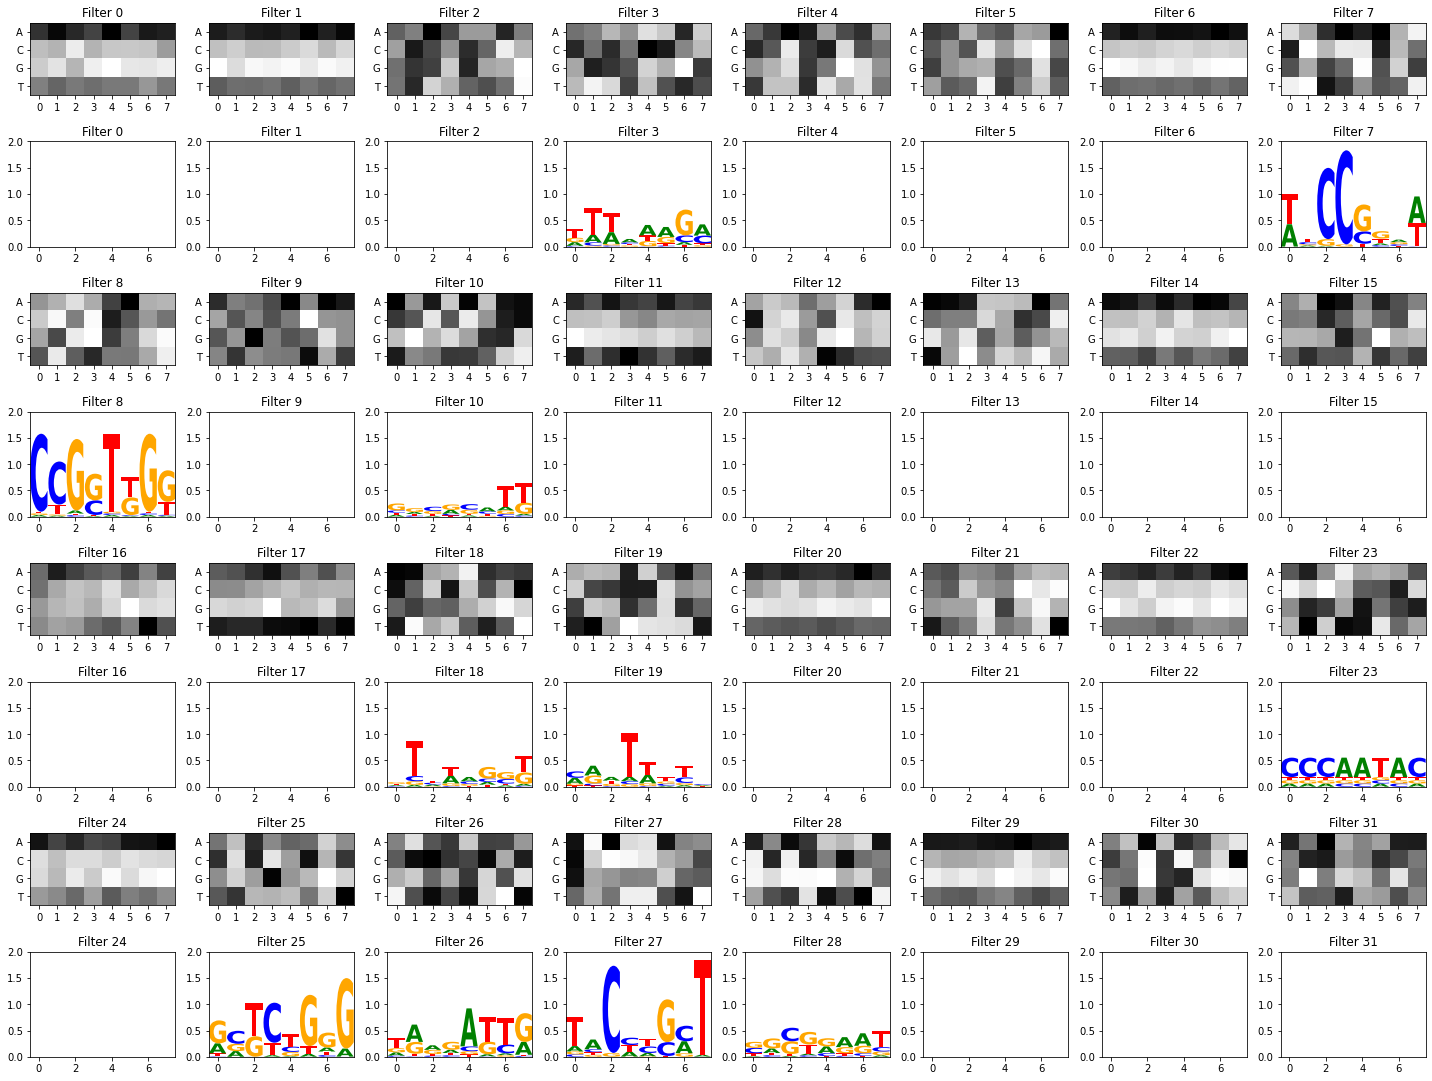

In [181]:
view_filters_and_logos(model_weights,filter_activations)

## sometimes the CNN filter viz's all come back empty... like none of them activated for anything? Again, wondering if just cuz teh model's still bad?

In [182]:
train_df.shape

(3370, 6)

In [183]:
test_df.shape

(843, 6)

In [185]:
model_weights[0][27]

tensor([[[-0.1794,  0.0953, -0.2002,  0.0588,  0.0695, -0.1782, -0.0438,
          -0.0335],
         [-0.1917,  0.0448,  0.1006,  0.0929,  0.0761,  0.0101, -0.0158,
          -0.1172],
         [-0.1809, -0.0006, -0.0227, -0.0439, -0.0407,  0.0446, -0.0785,
          -0.0912],
         [-0.0778,  0.0060, -0.0629,  0.0827,  0.0830, -0.1064, -0.1765,
           0.1022]]], grad_fn=<SelectBackward>)

In [186]:
model_weights[0][25]

tensor([[[-0.0508,  0.0493, -0.1441, -0.0237, -0.0729, -0.0629,  0.0721,
          -0.0183],
         [-0.1413,  0.0902, -0.1610,  0.0982,  0.0048, -0.1820,  0.0345,
          -0.1316],
         [-0.0169,  0.0728,  0.0050, -0.1994, -0.0062,  0.0392,  0.1323,
           0.0744],
         [-0.0877, -0.1330,  0.0371,  0.0317,  0.0451, -0.0488,  0.0691,
          -0.2035]]], grad_fn=<SelectBackward>)

In [187]:
filter_activations

{0: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 2: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 3: tensor([[ 4224.,  3994.,  6990.,  9101.,  9793., 10234.,  1474., 10200.],
         [  844.,  1726.,   713.,  4357.,   258.,  1112.,  3683.,  7050.],
         [ 5046.,   526.,   877.,  2997.,  5015.,  6342., 14084.,  1244.],
         [10090., 13958., 11624.,  3749.,  5138.,  2516.,   963.,  1710.]]),
 4: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

In [151]:
s = "CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT"
cv = conv_layers[0]
res = get_conv_output_for_seq(s, cv)

Running seq CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT


In [154]:
res[0]

tensor([[ -9.5746,  -9.4924,  -7.4644, -12.4131,  -9.3766, -12.4773,  -9.3960,
          -8.9915, -10.0036, -15.8174, -11.0617,  -9.1470, -11.6671,  -8.2978,
          -9.1411, -10.9788,  -9.1689,  -7.6458, -11.4770,  -7.7633,  -9.7536,
         -10.8268,  -8.3790,  -7.6119, -13.8003,  -9.7148, -10.7128,  -8.9994,
          -7.5161, -13.8485, -12.9574,  -8.7443,  -9.2733, -10.6395,  -8.6432,
         -12.2618, -10.2630, -11.1075,  -9.0176, -11.4900, -10.3899, -10.3149,
          -7.0597, -10.3635,  -8.5172, -12.8237, -10.7684, -10.5156, -12.9519,
         -11.4428,  -9.7300, -12.1845, -10.0502, -11.3992, -12.7044,  -9.2162,
         -13.7563,  -9.9278, -11.3679, -14.1289,  -9.6785, -12.0439, -10.7103,
          -8.0766, -13.5071, -10.9650, -10.9746,  -9.5969, -11.9218, -11.2454,
         -11.9609,  -7.3080, -11.2955, -11.3575, -10.6775, -11.5281, -11.9792,
          -7.2860,  -9.5770,  -8.8040, -10.6820,  -9.2874, -10.4569,  -9.5704,
          -9.8257, -10.7843,  -9.3882, -10.3675, -10

### Ok this seems to be running. The loss is exploding upward. Not yet sure if that's because it's a terrible model or if I've done something incorrectly. TBD

Or maybe it's the outlier loss issue coming back to bite us already!

# misc old stuff

In [11]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y

In [12]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)
full_df.head()

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728


In [13]:
tpm_df.head()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...,1318,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...,1102,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...,1081,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...,2416,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
4,EQU24_RS00025,hypothetical protein,CDS,,NZ_CP035467.1,6825,7062,Derived by automated computational analysis us...,VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...,238,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192


In [15]:
full_df.head()

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728


In [18]:
len(X.upstream_region.values[0])

100

In [20]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


## Linear model arch

In [ ]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size,num_heads):
        super().__init__()
        self.lin = nn.Linear(4*seq_len, h1_size)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)